In [58]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from copy import copy
import re

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import utils.DataSplitter
import utils.Sklearn
from utils.metrics import *
from utils.ColumnEnum import Columns

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [52]:
level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_level_line = df_level[df_level['line'] == line]
df_train, df_val = utils.DataSplitter.performTrainValSplit(df=df_level_line)

to_drop = [target]
X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=to_drop)
y_train = df_train[target]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                         dropSpecific=to_drop)
y_val = df_val[target]

print(all(X_train.columns == X_val.columns))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.columns)

True
(14680, 29) (14680,) (1840, 29) (1840,)
Index(['peakHour', 'Q1', 'Q2', 'Q3', 'Q4', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun', 'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan',
       'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation',
       'easterVacation', 'acc_precip', 'bright_sunshine', 'mean_cloud_cover',
       'mean_pressure', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed',
       'snow_depth', 'event'],
      dtype='object')


In [59]:
# for testing
level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

to_drop = [target]

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_train = df_level[df_level['line'] == line]

X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=True, dropCalendar=False, 
                                           dropSpecific=to_drop)
y_train = df_train[target]

df_train.index = pd.RangeIndex(start=0, stop=df_train.shape[0])
X_train.index = df_train.index
y_train.index = df_train.index


df_level_test = utils.DataSplitter.getTestData(agglevel=level, diff=False)
df_val = df_level_test[df_level_test['line'] == line]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=True, dropCalendar=False, 
                                           dropSpecific=to_drop)
y_val = df_val[target]

df_val.index = pd.RangeIndex(start = X_train.shape[0], stop = X_train.shape[0] + X_val.shape[0])
X_val.index = df_val.index
y_val.index = df_val.index

print(all(X_train.columns == X_val.columns))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.columns)

True
(16520, 21) (16520,) (1840, 21) (1840,)
Index(['peakHour', 'Q1', 'Q2', 'Q3', 'Q4', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun', 'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan',
       'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation',
       'easterVacation', 'event'],
      dtype='object')


# Random Forest

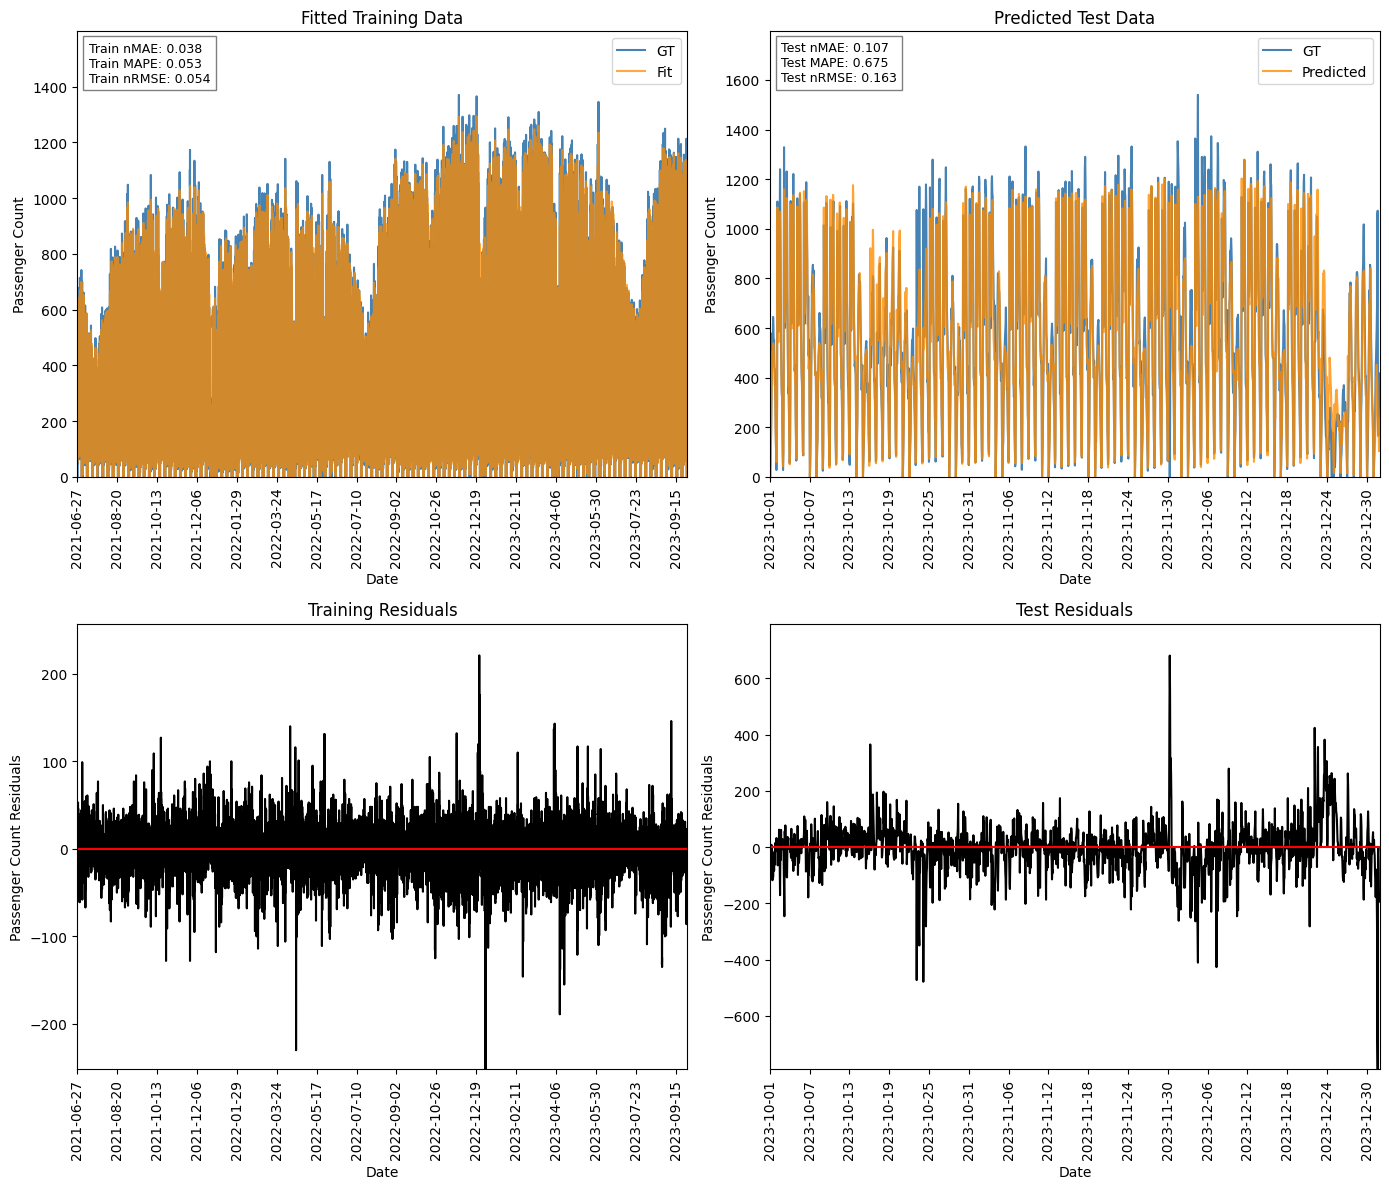

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
RandomForestRegressor(n_estimators=250, random_state=42)


In [30]:
# fixed window 40 hours ahead
horizon = 40*agg

# best 60 min without diff
lags = [20*agg, 40*agg, 60*agg, 80*agg, 100*agg, 120*agg, 140*agg]
differentiation = None
n_estimators = 250

# best 60 min with diff
#lags = [20, 40, 60, 80, 100, 120, 140]
#differentiation = 1
#n_estimators = 250


model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None#X_train.shape[0]
use_exog = True
interval = None#[25, 75]

model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
    differentiation=differentiation, lags=lags, window_type=window_type, window_size=window_size,
    interval=interval, horizon=horizon, 
    use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model)

utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_test_pred=y_val_pred,
                                  y_train_true=y_train, y_test_true=y_val,
                                  y_test_lower=None, y_test_upper=None,
                                  dates=True, trainDateCol=df_train['date'], testDateCol=df_val['date'])

print(model.get_params())
print(model)

## Grid search

In [3]:
horizon = 40*agg
window_list = ['fixed']
scalar = StandardScaler()
exog_scalar = StandardScaler()
#iterator = 0

for window_type in window_list:
    for useLags in [False, True]:
        for dropCalendar in [True, False]:
            for dropWeather in [True, False]:
                for diff in [1, None]:
                    if useLags == False and dropCalendar == True and dropWeather == True:
                        break

                    X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, 
                                                               dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                               dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, 
                                                             dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                             dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    if useLags:
                        laglist = [[1], [4], [8], [20], [40], [60], [80], [100], [120], [140],
                                   [1, 20, 140], 
                                   [1, 4, 8, 20],
                                   [1, 10, 20, 140],
                                   [1, 4, 8, 20, 140],
                                   [20, 40, 60, 80, 100, 120, 140],
                                   [1, 20, 40, 60, 80, 100, 120, 140]]
                        laglist = [[i*agg for i in templist] for templist in laglist]
                    else:
                        laglist = [None]
                    
                    if window_type == 'rolling':
                        window_size = X_train.shape[0]
                    else:
                        window_size = None
                    
                    use_exog = True if dropCalendar == False or dropWeather == False else False

                    bestMAE = 1000000
                    # begin grid search
                    for n_estimators in [5, 10, 20, 30, 50, 100, 250]:
                        for lags in laglist:
                            model = RandomForestRegressor(
                                n_estimators=n_estimators,
                                random_state=42)
                            model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
                                differentiation=diff, lags=lags, window_type=window_type, window_size=window_size,
                                horizon=horizon, use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
                                X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model, interval=None)
                                        
                            trainMAE = nMAE(y=y_train, yhat=y_train_pred)
                            valMAE = nMAE(y=y_val, yhat=y_val_pred)
                            if valMAE < bestMAE:
                                bestMAE = valMAE
                                best_model = model
                                best_y_train_pred = y_train_pred
                                best_y_val_pred = y_val_pred
                                best_lags = lags
                                best_n_estimator = n_estimators
                    # end grid search
                    
                    trainMAE = nMAE(y=y_train, yhat=best_y_train_pred)
                    valMAE = nMAE(y=y_val, yhat=best_y_val_pred)
                    trainMAPE = MAPE(y=y_train, yhat=best_y_train_pred)
                    valMAPE = MAPE(y=y_val, yhat=best_y_val_pred)
                    trainRMSE = nRMSE(y=y_train, yhat=best_y_train_pred)
                    valRMSE = nRMSE(y=y_val, yhat=best_y_val_pred)
                    #print('')
                    #print(window_type, f'Lags:{useLags}', f'Drop cal:{dropCalendar}', f'drop Weather:{dropWeather}', f'Diff:{diff}')
                    #print(model, f'Lags:{best_lags}')
                    #print(trainMAE, trainMAPE, trainRMSE)
                    #print(valMAE, valMAPE, valRMSE)
                    with open(f"hyperparameterSearch/{best_model.__class__.__name__}GridSearch.txt", "a") as f:
                        f.write(f"Window: {window_type}, Line: {line}, Lags: {useLags}, Drop C: {dropCalendar}, Drop W: {dropWeather}, Diff: {diff}\n")
                        f.write("Best hyperparameters:\n")
                        f.write(f"lags: {best_lags}\n")
                        f.write(f"n_estimators {best_n_estimator}\n")
                        f.write(f"Train metrics:\n")
                        f.write(f"nMAE: {trainMAE}, MAPE: {trainMAPE}, nRMSE: {trainRMSE}\n")
                        f.write(f"Val metrics:\n")
                        f.write(f"nMAE: {valMAE}, MAPE: {valMAPE}, nRMSE: {valRMSE}\n")
                        f.write("------------------------------------------------------------------------------\n")

1A 60min:

Diff=None

$$
\begin{array}{c|c|c}
Model    & n\_estimators & Lags\\
\hline
F-RF-W   & 100      & None\\
\hline
F-RF-C   & 5      & None\\
\hline
F-RF-CW  & 30      & None\\
\hline
F-RF-L   & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LW  & 100      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LC  & 100      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LCW & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$


Diff=1

$$
\begin{array}{c|c|c}
Model    & n\_estimators & Lags\\
\hline
F-RF-W   & 250      & None\\
\hline
F-RF-C   & 50      & None\\
\hline
F-RF-CW  & 250      & None\\
\hline
F-RF-L   & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LW  & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LC  & 250      & [1, 4, 8, 20, 140]\\
\hline
F-RF-LCW & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$

# XGBoost

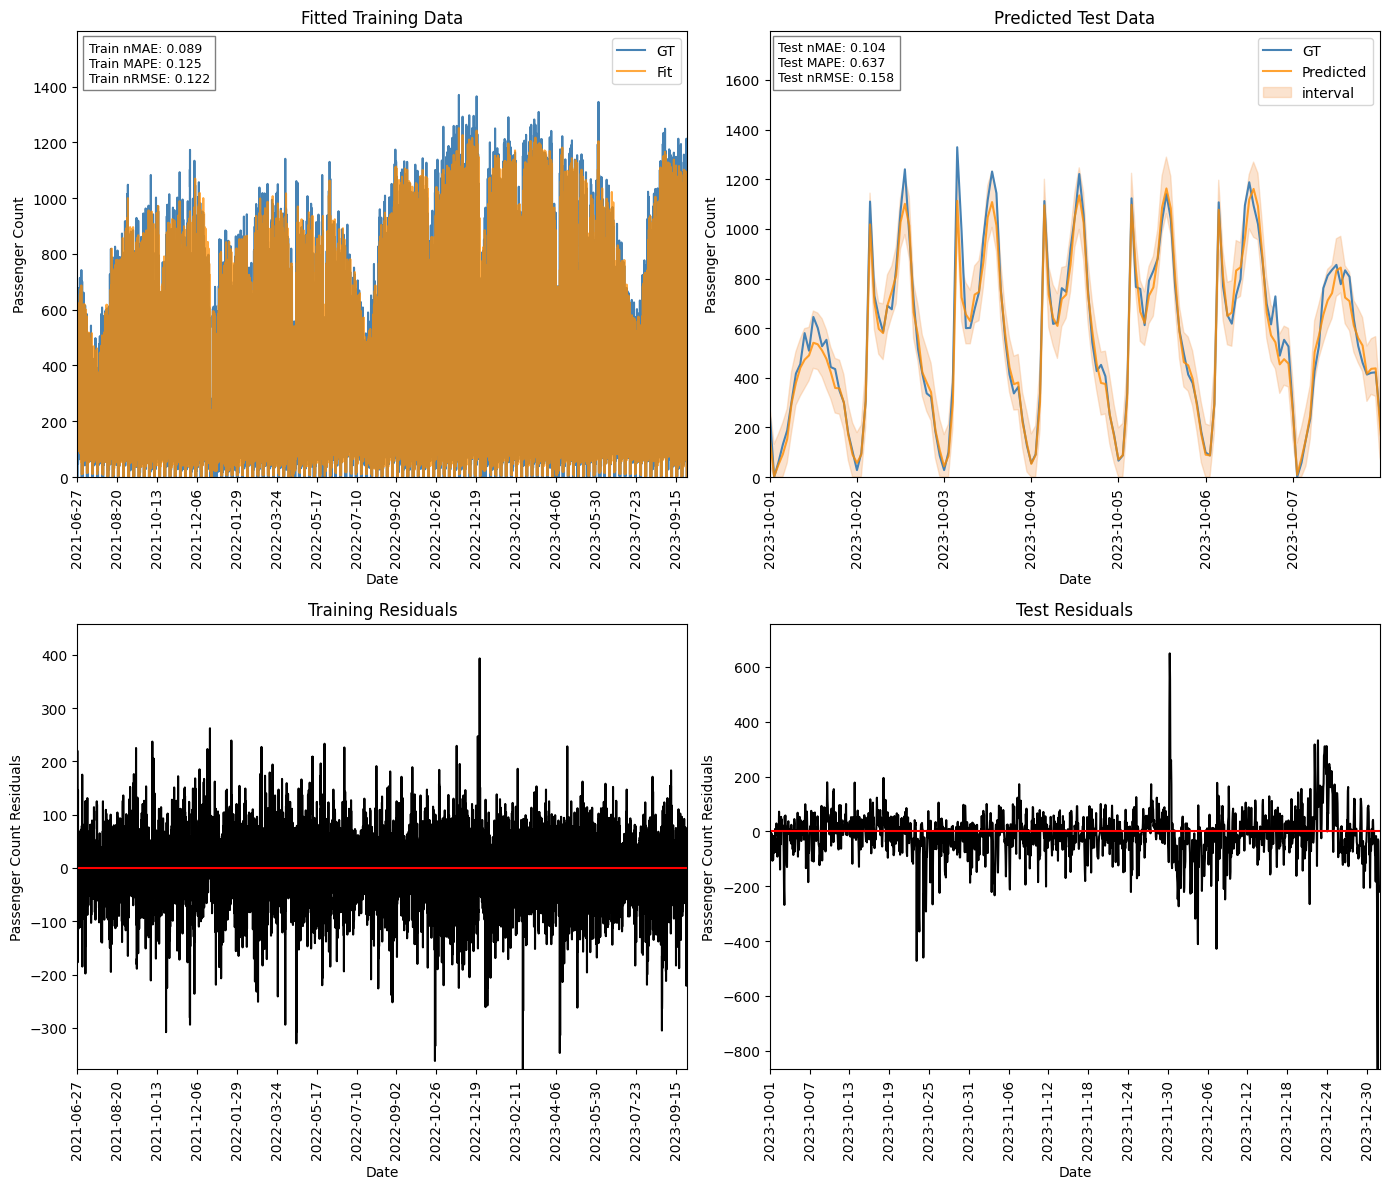

In [60]:
# fixed window 40 hours ahead
horizon = 40*agg

# 1. best 60 min without diff
differentiation = None
lags = [20*agg, 40*agg, 60*agg, 80*agg, 100*agg, 120*agg, 140*agg]
n_estimators = 100
alpha = 0.3
eta = 0.1

# 2. best 60 min without diff
#differentiation = None
#lags = [20*agg, 40*agg, 60*agg, 80*agg, 100*agg, 120*agg, 140*agg]
#n_estimators = 50
#alpha = 0.1
#eta = 0.1

# 2. best 60 min with diff
#differentiation = 1
#lags = [20, 40, 60, 80, 100, 120, 140]
#n_estimators = 20
#alpha = 0.0
#eta = 0.2

model = XGBRegressor(n_estimators=n_estimators, alpha=alpha, eta=eta, seed=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None#X_train.shape[0]
use_exog = True
interval = [2.5, 97.5]

model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
    differentiation=differentiation, lags=lags, window_type=window_type, window_size=window_size,
    interval=interval, horizon=horizon, 
    use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model)

#utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_test_pred=y_val_pred,
#                                  y_train_true=y_train, y_test_true=y_val,
#                                  y_test_lower=None, y_test_upper=None,
#                                  dates=True, trainDateCol=df_train['date'], testDateCol=df_val['date'],
#                                  xlim_lower=None, xlim_upper=None)

utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_test_pred=y_val_pred['pred'],
                                  y_train_true=y_train, y_test_true=y_val,
                                  y_test_lower=y_val_pred['lower_bound'], y_test_upper=y_val_pred['upper_bound'],
                                  dates=True, trainDateCol=df_train['date'], testDateCol=df_val['date'],
                                  xlim_lower=16520, xlim_upper=16520+140)

In [61]:

inside_interval = np.where(
                     (y_val >= y_val_pred['lower_bound']) & \
                     (y_val <= y_val_pred['upper_bound']),
                     True,
                     False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * coverage}")

Coverage of the predicted interval on test data: 88.58695652173914


In [62]:
1-y_val_pred[(y_val < y_val_pred['lower_bound']) | (y_val > y_val_pred['upper_bound'])].shape[0]/y_val.shape[0]

0.8858695652173914

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

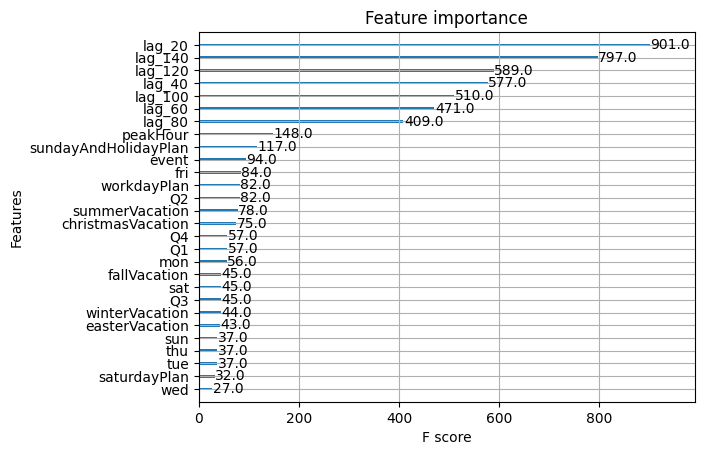

In [63]:
from xgboost import plot_importance
plot_importance(model, max_num_features=36, importance_type='weight')

## Grid search

In [54]:
horizon = 40*agg
window_list = ['fixed']
scalar = StandardScaler()
exog_scalar = StandardScaler()

for window_type in window_list:
    for useLags in [False, True]:
        for dropCalendar in [True, False]:
            for dropWeather in [True, False]:
                for diff in [1, None]:
                    if useLags == False and dropCalendar == True and dropWeather == True:
                        break

                    X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, 
                                                               dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                               dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, 
                                                             dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                             dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    if useLags:
                        laglist = [[1], [4], [8], [20], [40], [60], [80], [100], [120], [140],
                                   [1, 20, 140], 
                                   [1, 4, 8, 20],
                                   [1, 10, 20, 140],
                                   [1, 4, 8, 20, 140],
                                   [20, 40, 60, 80, 100, 120, 140],
                                   [1, 20, 40, 60, 80, 100, 120, 140]]
                        laglist = [[i*agg for i in templist] for templist in laglist]
                    else:
                        laglist = [None]
                    
                    if window_type == 'rolling':
                        window_size = X_train.shape[0]
                    else:
                        window_size = None
                    
                    use_exog = True if dropCalendar == False or dropWeather == False else False

                    bestMAE = 1000000
                    # begin grid search
                    for n_estimators in [5, 10, 20, 30, 50, 100, 250]:
                        for alpha in [0.0, 0.1, 0.2, 0.3, 0.5]:
                            for eta in [0.01, 0.05, 0.1, 0.2, 0.3]: #[]:
                                for lags in laglist:
                                    model = XGBRegressor(n_estimators=n_estimators, 
                                                         eta=eta,
                                                         alpha=alpha, 
                                                         seed=42)
                                    model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
                                        differentiation=diff, lags=lags, window_type=window_type, window_size=window_size,
                                        horizon=horizon, use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
                                        X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model, interval=None)
                                    
                                    trainMAE = nMAE(y=y_train, yhat=y_train_pred)
                                    valMAE = nMAE(y=y_val, yhat=y_val_pred)
                                    if valMAE < bestMAE:
                                        bestMAE = valMAE
                                        best_model = model
                                        best_y_train_pred = y_train_pred
                                        best_y_val_pred = y_val_pred
                                        best_n_estimator = n_estimators
                                        best_alpha = alpha
                                        best_eta = eta
                                        best_lags = lags
                    # end grid search
                    
                    trainMAE = nMAE(y=y_train, yhat=best_y_train_pred)
                    valMAE = nMAE(y=y_val, yhat=best_y_val_pred)
                    trainMAPE = MAPE(y=y_train, yhat=best_y_train_pred)
                    valMAPE = MAPE(y=y_val, yhat=best_y_val_pred)
                    trainRMSE = nRMSE(y=y_train, yhat=best_y_train_pred)
                    valRMSE = nRMSE(y=y_val, yhat=best_y_val_pred)
                    #print('')
                    #print(window_type, f'Lags:{useLags}', f'Drop cal:{dropCalendar}', f'drop Weather:{dropWeather}', f'Diff:{diff}')
                    #print(model.get_xgb_params(), f'Lags:{best_lags}')
                    #print(trainMAE, trainMAPE, trainRMSE)
                    #print(valMAE, valMAPE, valRMSE)
                    with open(f"hyperparameterSearch/{model.__class__.__name__}GridSearch.txt", "a") as f:
                        f.write(f"Window: {window_type}, Line: {line}, Lags: {useLags}, Drop C: {dropCalendar}, Drop W: {dropWeather}, Diff: {diff}\n")
                        f.write("Best hyperparameters:\n")
                        f.write(f"lags: {best_lags}\n")
                        f.write(f"n_estimators {best_n_estimator}, alpha L1: {best_alpha}, eta: {best_eta}\n")
                        f.write(f"Train metrics:\n")
                        f.write(f"nMAE: {trainMAE}, MAPE: {trainMAPE}, nRMSE: {trainRMSE}\n")
                        f.write(f"Val metrics:\n")
                        f.write(f"nMAE: {valMAE}, MAPE: {valMAPE}, nRMSE: {valRMSE}\n")
                        f.write("------------------------------------------------------------------------------\n")

1A 60min:

Diff=None

$$
\begin{array}{c|c|c|c|c}
Model     & n\_estimators & \alpha L1 & \eta & Lags\\
\hline
F-XGB-W   & 10            & 0.3       & 0.2  & None\\
\hline
F-XGB-C   & 10            & 0.0       & 0.2  & None\\
\hline
F-XGB-CW  & 10            & 0.1       & 0.3  & None\\
\hline
F-XGB-L   & 100           & 0.5       & 0.1  & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-XGB-LW  & 100           & 0.0       & 0.05 & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-XGB-LC  & 100           & 0.3       & 0.1  & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-XGB-LCW & 50            & 0.1       & 0.1  & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$


Diff=1

$$
\begin{array}{c|c|c|c|c}
Model     & n\_estimators & \alpha (L1) & \eta & Lags\\
\hline
F-XGB-W   & 5             & 0.2       & 0.3  & None\\
\hline
F-XGB-C   & 20            & 0.3       & 0.2  & None\\
\hline
F-XGB-CW  & 100           & 0.2       & 0.1  & None\\
\hline
F-XGB-L   & 50            & 0.0       & 0.1  & [1, 4, 8, 20, 140]\\
\hline
F-XGB-LW  & 100           & 0.3       & 0.05 & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-XGB-LC  & 250           & 0.2       & 0.05 & [1, 20, 140]\\
\hline
F-XGB-LCW & 20            & 0.0       & 0.2  & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$

# Write Anatomy and plot PBSV

In [14]:
import os
from anatomy import *

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def train_lasso(x_train: pd.DataFrame, y_train: pd.Series) -> AnatomyModel:
    lasso_model = Lasso(alpha=0.005, fit_intercept=True, random_state=42)
    lasso_model.fit(x_train, y_train)

    def pred_fn_lasso(xs: np.ndarray) -> np.ndarray:
        xs_df = pd.DataFrame(xs, columns=x_train.columns)
        return np.array(lasso_model.predict(xs_df)).flatten()

    return AnatomyModel(pred_fn_lasso)

def train_rf(x_train: pd.DataFrame, y_train: pd.Series) -> AnatomyModel:
    rf_model = RandomForestRegressor(n_estimators=250, random_state=42)
    rf_model.fit(x_train, y_train)

    def pred_fn_rf(xs: np.ndarray) -> np.ndarray:
        xs_df = pd.DataFrame(xs, columns=x_train.columns)
        return np.array(rf_model.predict(xs_df)).flatten()

    return AnatomyModel(pred_fn_rf)

def train_xgb(x_train: pd.DataFrame, y_train: pd.Series) -> AnatomyModel:
    xgb_model = XGBRegressor(n_estimators=50, alpha=0.1, eta=0.1, seed=42)
    xgb_model.fit(x_train, y_train)

    def pred_fn_xgb(xs: np.ndarray) -> np.ndarray:
        xs_df = pd.DataFrame(xs, columns=x_train.columns)
        return np.array(xgb_model.predict(xs_df)).flatten()

    return AnatomyModel(pred_fn_xgb)


def generate_data(n_predictors=3) -> [pd.DataFrame, AnatomySubsets]:
    xy = copy(pd.concat([X_train, X_val]))
    scalar = StandardScaler()
    xy = pd.DataFrame(scalar.fit_transform(xy), columns=xy.columns)

    xy['y'] = copy(pd.concat([y_train, y_val]))
    for i in [20, 40, 60, 80, 100, 120, 140]:
        xy[f'{i}'] = xy['y'].shift(periods=i).fillna(0)

    subsets = AnatomySubsets.generate(
        index=xy.index,
        initial_window=X_train.shape[0],
        estimation_type=AnatomySubsets.EstimationType.EXPANDING,
        periods=1,
        gap=0
    )

    return xy, subsets

## XGBoost

In [10]:
def estimate_anatomy(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    def mapper(key: AnatomyModelProvider.PeriodKey) -> \
            AnatomyModelProvider.PeriodValue:
        train = xy.iloc[subsets.get_train_subset(key.period)]
        test = xy.iloc[subsets.get_test_subset(key.period)]

        if key.model_name == "lasso":
            model = train_lasso(train.drop("y", axis=1), train["y"])
        if key.model_name == "rf":
            model = train_rf(train.drop("y", axis=1), train["y"])
        if key.model_name == "xgb":
            model = train_xgb(train.drop("y", axis=1), train["y"])

        return AnatomyModelProvider.PeriodValue(train, test, model)

    provider = AnatomyModelProvider(
        n_periods=subsets.n_periods,
        n_features=xy.shape[1] - 1,
        model_names=["xgb"],
        y_name="y",
        provider_fn=mapper
    )

    Anatomy(provider=provider, n_iterations=10).precompute(
        n_jobs=max(1, min(os.cpu_count(), 16)), save_path="anatomyXGBtest.bin"
    )

# set random seed for reproducibility:
np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

estimate_anatomy(xy, subsets)
print('anatomy estimated')

data generated
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed:   11.5s
[Parallel(n_jobs=11)]: Done   2 tasks      | elapsed:   11.5s
[Parallel(n_jobs=11)]: Done   3 tasks      | elapsed:   11.6s
[Parallel(n_jobs=11)]: Done   4 tasks      | elapsed:   11.6s
[Parallel(n_jobs=11)]: Done   5 tasks      | elapsed:   12.0s
[Parallel(n_jobs=11)]: Done   6 tasks      | elapsed:   12.0s
[Parallel(n_jobs=11)]: Done   7 tasks      | elapsed:   12.0s
[Parallel(n_jobs=11)]: Done   8 tasks      | elapsed:   12.1s
[Parallel(n_jobs=11)]: Done   9 tasks      | elapsed:   12.1s
[Parallel(n_jobs=11)]: Done  10 tasks      | elapsed:   12.2s
[Parallel(n_jobs=11)]: Done  11 tasks      | elapsed:   12.2s
[Parallel(n_jobs=11)]: Done  12 tasks      | elapsed:   22.0s
[Parallel(n_jobs=11)]: Done  13 tasks      | elapsed:   22.3s
[Parallel(n_jobs=11)]: Done  14 tasks      | elapsed:   22.3s
[Parallel(n_jobs=11)]: Done  15 tasks   

## Random Forest

In [15]:
def estimate_anatomy(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    def mapper(key: AnatomyModelProvider.PeriodKey) -> \
            AnatomyModelProvider.PeriodValue:
        train = xy.iloc[subsets.get_train_subset(key.period)]
        test = xy.iloc[subsets.get_test_subset(key.period)]

        if key.model_name == "lasso":
            model = train_lasso(train.drop("y", axis=1), train["y"])
        if key.model_name == "rf":
            model = train_rf(train.drop("y", axis=1), train["y"])
        if key.model_name == "xgb":
            model = train_xgb(train.drop("y", axis=1), train["y"])

        return AnatomyModelProvider.PeriodValue(train, test, model)

    provider = AnatomyModelProvider(
        n_periods=subsets.n_periods,
        n_features=xy.shape[1] - 1,
        model_names=["rf"],
        y_name="y",
        provider_fn=mapper
    )

    Anatomy(provider=provider, n_iterations=5).precompute(
        n_jobs=max(1, min(os.cpu_count(), 16)), save_path="anatomyRFtest.bin"
    )

# set random seed for reproducibility:
np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

estimate_anatomy(xy, subsets)
print('anatomy estimated')

data generated
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done   3 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done   4 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done   6 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done   7 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done   8 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done  11 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done  12 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done  13 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done  14 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done  15 tasks   

## Lasso

In [9]:
def estimate_anatomy(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    def mapper(key: AnatomyModelProvider.PeriodKey) -> \
            AnatomyModelProvider.PeriodValue:
        train = xy.iloc[subsets.get_train_subset(key.period)]
        test = xy.iloc[subsets.get_test_subset(key.period)]

        if key.model_name == "lasso":
            model = train_lasso(train.drop("y", axis=1), train["y"])
        if key.model_name == "rf":
            model = train_rf(train.drop("y", axis=1), train["y"])
        if key.model_name == "xgb":
            model = train_xgb(train.drop("y", axis=1), train["y"])

        return AnatomyModelProvider.PeriodValue(train, test, model)

    provider = AnatomyModelProvider(
        n_periods=subsets.n_periods,
        n_features=xy.shape[1] - 1,
        model_names=["lasso"],
        y_name="y",
        provider_fn=mapper
    )

    Anatomy(provider=provider, n_iterations=10).precompute(
        n_jobs=max(1, min(os.cpu_count(), 16)), save_path="anatomyLassotest.bin"
    )

# set random seed for reproducibility:
np.random.seed(42)
xy, subsets = generate_data()
print('data generated')

estimate_anatomy(xy, subsets)
print('anatomy estimated')

data generated
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e+06, tolerance: 1.223e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+06, tolerance: 1.224e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=11)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=11)]: Done   3 tasks      | elapsed:    4.3s
[Parallel(n_jobs=11)]: Done   4 tasks      | elapsed:    4.3s
[Parallel(n_jobs=11)]: Done   5 tasks      | elapsed:    4.4s
[Parallel(n_jobs=11)]: Done   6 tasks      | elapsed:    4.4s
[Parallel(n_jobs=11)]: Done   7 tasks      | elapsed:    4.4s
[Parallel(n_jobs=11)]: Done   8 tasks      | elapsed:    4.5s
[Parallel(n_jobs=11)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=11)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=11)]: Done  11 tasks      | elapsed:    4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.224e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+06, tolerance: 1.224e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  12 tasks      | elapsed:    6.5s
[Parallel(n_jobs=11)]: Done  13 tasks      | elapsed:    7.2s
[Parallel(n_jobs=11)]: Done  14 tasks      | elapsed:    7.3s
[Parallel(n_jobs=11)]: Done  15 tasks      | elapsed:    7.4s
[Parallel(n_jobs=11)]: Done  16 tasks      | elapsed:    7.4s
[Parallel(n_jobs=11)]: Done  17 tasks      | elapsed:    7.5s
[Parallel(n_jobs=11)]: Done  18 tasks      | elapsed:    7.6s
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:    7.7s
[Parallel(n_jobs=11)]: Done  20 tasks      | elapsed:    7.7s
[Parallel(n_jobs=11)]: Done  21 tasks      | elapsed:    7.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.297e+06, tolerance: 1.225e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  22 tasks      | elapsed:    7.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.299e+06, tolerance: 1.225e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+06, tolerance: 1.225e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  23 tasks      | elapsed:    9.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.317e+06, tolerance: 1.226e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  24 tasks      | elapsed:    9.6s
[Parallel(n_jobs=11)]: Done  25 tasks      | elapsed:   10.1s
[Parallel(n_jobs=11)]: Done  26 tasks      | elapsed:   10.2s
[Parallel(n_jobs=11)]: Done  27 tasks      | elapsed:   10.2s
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:   10.3s
[Parallel(n_jobs=11)]: Done  29 tasks      | elapsed:   10.3s
[Parallel(n_jobs=11)]: Done  30 tasks      | elapsed:   10.4s
[Parallel(n_jobs=11)]: Done  31 tasks      | elapsed:   10.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+06, tolerance: 1.227e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  32 tasks      | elapsed:   10.6s
[Parallel(n_jobs=11)]: Done  33 tasks      | elapsed:   10.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+06, tolerance: 1.227e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.322e+06, tolerance: 1.227e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  34 tasks      | elapsed:   11.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e+06, tolerance: 1.227e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e+06, tolerance: 1.227e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  35 tasks      | elapsed:   12.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e+06, tolerance: 1.228e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  36 tasks      | elapsed:   13.2s
[Parallel(n_jobs=11)]: Done  37 tasks      | elapsed:   13.3s
[Parallel(n_jobs=11)]: Done  38 tasks      | elapsed:   13.3s
[Parallel(n_jobs=11)]: Done  39 tasks      | elapsed:   13.4s
[Parallel(n_jobs=11)]: Done  40 tasks      | elapsed:   13.4s
[Parallel(n_jobs=11)]: Done  41 tasks      | elapsed:   13.4s
[Parallel(n_jobs=11)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=11)]: Done  43 tasks      | elapsed:   13.7s
[Parallel(n_jobs=11)]: Done  44 tasks      | elapsed:   13.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e+06, tolerance: 1.228e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  45 tasks      | elapsed:   14.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.332e+06, tolerance: 1.228e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.332e+06, tolerance: 1.228e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  46 tasks      | elapsed:   15.7s
[Parallel(n_jobs=11)]: Done  47 tasks      | elapsed:   16.4s
[Parallel(n_jobs=11)]: Done  48 tasks      | elapsed:   16.5s
[Parallel(n_jobs=11)]: Done  49 tasks      | elapsed:   16.5s
[Parallel(n_jobs=11)]: Done  50 tasks      | elapsed:   16.5s
[Parallel(n_jobs=11)]: Done  51 tasks      | elapsed:   16.6s
[Parallel(n_jobs=11)]: Done  52 tasks      | elapsed:   16.6s
[Parallel(n_jobs=11)]: Done  53 tasks      | elapsed:   16.6s
[Parallel(n_jobs=11)]: Done  54 tasks      | elapsed:   16.7s
[Parallel(n_jobs=11)]: Done  55 tasks      | elapsed:   16.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.331e+06, tolerance: 1.230e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  56 tasks      | elapsed:   17.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e+06, tolerance: 1.231e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e+06, tolerance: 1.230e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  57 tasks      | elapsed:   18.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e+06, tolerance: 1.231e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  58 tasks      | elapsed:   19.2s
[Parallel(n_jobs=11)]: Done  59 tasks      | elapsed:   19.2s
[Parallel(n_jobs=11)]: Done  60 tasks      | elapsed:   19.2s
[Parallel(n_jobs=11)]: Done  61 tasks      | elapsed:   19.3s
[Parallel(n_jobs=11)]: Done  62 tasks      | elapsed:   19.3s
[Parallel(n_jobs=11)]: Done  63 tasks      | elapsed:   19.4s
[Parallel(n_jobs=11)]: Done  64 tasks      | elapsed:   19.4s
[Parallel(n_jobs=11)]: Done  65 tasks      | elapsed:   19.5s
[Parallel(n_jobs=11)]: Done  66 tasks      | elapsed:   19.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e+06, tolerance: 1.231e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  67 tasks      | elapsed:   19.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e+06, tolerance: 1.232e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e+06, tolerance: 1.232e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  68 tasks      | elapsed:   20.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.326e+06, tolerance: 1.233e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  69 tasks      | elapsed:   21.9s
[Parallel(n_jobs=11)]: Done  70 tasks      | elapsed:   21.9s
[Parallel(n_jobs=11)]: Done  71 tasks      | elapsed:   22.0s
[Parallel(n_jobs=11)]: Done  72 tasks      | elapsed:   22.0s
[Parallel(n_jobs=11)]: Done  73 tasks      | elapsed:   22.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.326e+06, tolerance: 1.233e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  74 tasks      | elapsed:   22.1s
[Parallel(n_jobs=11)]: Done  75 tasks      | elapsed:   22.2s
[Parallel(n_jobs=11)]: Done  76 tasks      | elapsed:   22.3s
[Parallel(n_jobs=11)]: Done  77 tasks      | elapsed:   22.3s
[Parallel(n_jobs=11)]: Done  78 tasks      | elapsed:   22.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.326e+06, tolerance: 1.233e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.326e+06, tolerance: 1.233e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  79 tasks      | elapsed:   23.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+06, tolerance: 1.234e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+06, tolerance: 1.234e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  80 tasks      | elapsed:   24.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+06, tolerance: 1.235e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  81 tasks      | elapsed:   24.7s
[Parallel(n_jobs=11)]: Done  82 tasks      | elapsed:   24.8s
[Parallel(n_jobs=11)]: Done  83 tasks      | elapsed:   24.8s
[Parallel(n_jobs=11)]: Done  84 tasks      | elapsed:   24.9s
[Parallel(n_jobs=11)]: Done  85 tasks      | elapsed:   24.9s
[Parallel(n_jobs=11)]: Done  86 tasks      | elapsed:   25.0s
[Parallel(n_jobs=11)]: Done  87 tasks      | elapsed:   25.0s
[Parallel(n_jobs=11)]: Done  88 tasks      | elapsed:   25.1s
[Parallel(n_jobs=11)]: Done  89 tasks      | elapsed:   25.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+06, tolerance: 1.235e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.323e+06, tolerance: 1.235e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  90 tasks      | elapsed:   25.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.323e+06, tolerance: 1.236e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.322e+06, tolerance: 1.236e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done  91 tasks      | elapsed:   26.9s
[Parallel(n_jobs=11)]: Done  92 tasks      | elapsed:   27.3s
[Parallel(n_jobs=11)]: Done  93 tasks      | elapsed:   27.4s
[Parallel(n_jobs=11)]: Done  94 tasks      | elapsed:   27.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+06, tolerance: 1.236e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done  95 tasks      | elapsed:   27.6s
[Parallel(n_jobs=11)]: Done  96 tasks      | elapsed:   27.6s
[Parallel(n_jobs=11)]: Done  97 tasks      | elapsed:   27.7s
[Parallel(n_jobs=11)]: Done  98 tasks      | elapsed:   27.8s
[Parallel(n_jobs=11)]: Done  99 tasks      | elapsed:   27.8s
[Parallel(n_jobs=11)]: Done 100 tasks      | elapsed:   28.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+06, tolerance: 1.236e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+06, tolerance: 1.236e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 101 tasks      | elapsed:   28.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+06, tolerance: 1.237e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+06, tolerance: 1.237e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 102 tasks      | elapsed:   29.6s
[Parallel(n_jobs=11)]: Done 103 tasks      | elapsed:   29.9s
[Parallel(n_jobs=11)]: Done 104 tasks      | elapsed:   30.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+06, tolerance: 1.238e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 105 tasks      | elapsed:   30.2s
[Parallel(n_jobs=11)]: Done 106 tasks      | elapsed:   30.2s
[Parallel(n_jobs=11)]: Done 107 tasks      | elapsed:   30.4s
[Parallel(n_jobs=11)]: Done 108 tasks      | elapsed:   30.4s
[Parallel(n_jobs=11)]: Done 109 tasks      | elapsed:   30.5s
[Parallel(n_jobs=11)]: Done 110 tasks      | elapsed:   30.5s
[Parallel(n_jobs=11)]: Done 111 tasks      | elapsed:   30.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+06, tolerance: 1.239e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+06, tolerance: 1.239e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 112 tasks      | elapsed:   31.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+06, tolerance: 1.239e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+06, tolerance: 1.239e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 113 tasks      | elapsed:   32.5s
[Parallel(n_jobs=11)]: Done 114 tasks      | elapsed:   32.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+06, tolerance: 1.239e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 115 tasks      | elapsed:   33.1s
[Parallel(n_jobs=11)]: Done 116 tasks      | elapsed:   33.3s
[Parallel(n_jobs=11)]: Done 117 tasks      | elapsed:   33.4s
[Parallel(n_jobs=11)]: Done 118 tasks      | elapsed:   33.4s
[Parallel(n_jobs=11)]: Done 119 tasks      | elapsed:   33.5s
[Parallel(n_jobs=11)]: Done 120 tasks      | elapsed:   33.6s
[Parallel(n_jobs=11)]: Done 121 tasks      | elapsed:   33.6s
[Parallel(n_jobs=11)]: Done 122 tasks      | elapsed:   33.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+06, tolerance: 1.240e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+06, tolerance: 1.240e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 123 tasks      | elapsed:   34.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+06, tolerance: 1.240e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+06, tolerance: 1.240e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 124 tasks      | elapsed:   35.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 125 tasks      | elapsed:   35.4s
[Parallel(n_jobs=11)]: Done 126 tasks      | elapsed:   35.9s
[Parallel(n_jobs=11)]: Done 127 tasks      | elapsed:   36.1s
[Parallel(n_jobs=11)]: Done 128 tasks      | elapsed:   36.2s
[Parallel(n_jobs=11)]: Done 129 tasks      | elapsed:   36.3s
[Parallel(n_jobs=11)]: Done 130 tasks      | elapsed:   36.3s
[Parallel(n_jobs=11)]: Done 131 tasks      | elapsed:   36.4s
[Parallel(n_jobs=11)]: Done 132 tasks      | elapsed:   36.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 133 tasks      | elapsed:   36.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 134 tasks      | elapsed:   36.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 135 tasks      | elapsed:   37.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 136 tasks      | elapsed:   38.4s
[Parallel(n_jobs=11)]: Done 137 tasks      | elapsed:   38.9s
[Parallel(n_jobs=11)]: Done 138 tasks      | elapsed:   39.0s
[Parallel(n_jobs=11)]: Done 139 tasks      | elapsed:   39.3s
[Parallel(n_jobs=11)]: Done 140 tasks      | elapsed:   39.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 141 tasks      | elapsed:   39.5s
[Parallel(n_jobs=11)]: Done 142 tasks      | elapsed:   39.6s
[Parallel(n_jobs=11)]: Done 143 tasks      | elapsed:   39.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.317e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 144 tasks      | elapsed:   39.9s
[Parallel(n_jobs=11)]: Done 145 tasks      | elapsed:   39.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.317e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.317e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 146 tasks      | elapsed:   40.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 147 tasks      | elapsed:   41.3s
[Parallel(n_jobs=11)]: Done 148 tasks      | elapsed:   42.0s
[Parallel(n_jobs=11)]: Done 149 tasks      | elapsed:   42.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 150 tasks      | elapsed:   42.3s
[Parallel(n_jobs=11)]: Done 151 tasks      | elapsed:   42.4s
[Parallel(n_jobs=11)]: Done 152 tasks      | elapsed:   42.5s
[Parallel(n_jobs=11)]: Done 153 tasks      | elapsed:   42.7s
[Parallel(n_jobs=11)]: Done 154 tasks      | elapsed:   42.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.241e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 155 tasks      | elapsed:   43.0s
[Parallel(n_jobs=11)]: Done 156 tasks      | elapsed:   43.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e+06, tolerance: 1.242e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 1.242e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 157 tasks      | elapsed:   43.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.322e+06, tolerance: 1.242e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+06, tolerance: 1.242e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 158 tasks      | elapsed:   44.3s
[Parallel(n_jobs=11)]: Done 159 tasks      | elapsed:   44.8s
[Parallel(n_jobs=11)]: Done 160 tasks      | elapsed:   44.9s
[Parallel(n_jobs=11)]: Done 161 tasks      | elapsed:   45.2s
[Parallel(n_jobs=11)]: Done 162 tasks      | elapsed:   45.3s
[Parallel(n_jobs=11)]: Done 163 tasks      | elapsed:   45.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.326e+06, tolerance: 1.242e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 164 tasks      | elapsed:   45.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e+06, tolerance: 1.242e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 165 tasks      | elapsed:   45.9s
[Parallel(n_jobs=11)]: Done 166 tasks      | elapsed:   46.1s
[Parallel(n_jobs=11)]: Done 167 tasks      | elapsed:   46.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e+06, tolerance: 1.243e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.332e+06, tolerance: 1.243e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 168 tasks      | elapsed:   46.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.339e+06, tolerance: 1.244e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 169 tasks      | elapsed:   47.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e+06, tolerance: 1.244e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.343e+06, tolerance: 1.244e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 170 tasks      | elapsed:   47.7s
[Parallel(n_jobs=11)]: Done 171 tasks      | elapsed:   47.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.346e+06, tolerance: 1.244e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 172 tasks      | elapsed:   48.2s
[Parallel(n_jobs=11)]: Done 173 tasks      | elapsed:   48.2s
[Parallel(n_jobs=11)]: Done 174 tasks      | elapsed:   48.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.348e+06, tolerance: 1.244e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 175 tasks      | elapsed:   48.5s
[Parallel(n_jobs=11)]: Done 176 tasks      | elapsed:   48.9s
[Parallel(n_jobs=11)]: Done 177 tasks      | elapsed:   48.9s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:   49.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.349e+06, tolerance: 1.244e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.349e+06, tolerance: 1.244e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 179 tasks      | elapsed:   49.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.349e+06, tolerance: 1.244e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.349e+06, tolerance: 1.244e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 180 tasks      | elapsed:   49.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.348e+06, tolerance: 1.245e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.349e+06, tolerance: 1.245e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 181 tasks      | elapsed:   50.6s
[Parallel(n_jobs=11)]: Done 182 tasks      | elapsed:   50.6s
[Parallel(n_jobs=11)]: Done 183 tasks      | elapsed:   51.1s
[Parallel(n_jobs=11)]: Done 184 tasks      | elapsed:   51.1s
[Parallel(n_jobs=11)]: Done 185 tasks      | elapsed:   51.1s
[Parallel(n_jobs=11)]: Done 186 tasks      | elapsed:   51.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.348e+06, tolerance: 1.245e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 187 tasks      | elapsed:   51.7s
[Parallel(n_jobs=11)]: Done 188 tasks      | elapsed:   51.7s
[Parallel(n_jobs=11)]: Done 189 tasks      | elapsed:   51.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.348e+06, tolerance: 1.245e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.348e+06, tolerance: 1.246e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 190 tasks      | elapsed:   52.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.348e+06, tolerance: 1.246e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.347e+06, tolerance: 1.246e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 191 tasks      | elapsed:   52.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.347e+06, tolerance: 1.246e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.346e+06, tolerance: 1.246e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 192 tasks      | elapsed:   53.3s
[Parallel(n_jobs=11)]: Done 193 tasks      | elapsed:   53.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.346e+06, tolerance: 1.246e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 194 tasks      | elapsed:   53.9s
[Parallel(n_jobs=11)]: Done 195 tasks      | elapsed:   54.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.346e+06, tolerance: 1.247e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 196 tasks      | elapsed:   54.1s
[Parallel(n_jobs=11)]: Done 197 tasks      | elapsed:   54.1s
[Parallel(n_jobs=11)]: Done 198 tasks      | elapsed:   54.5s
[Parallel(n_jobs=11)]: Done 199 tasks      | elapsed:   54.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.346e+06, tolerance: 1.247e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.346e+06, tolerance: 1.247e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 200 tasks      | elapsed:   54.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.345e+06, tolerance: 1.247e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 201 tasks      | elapsed:   55.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.345e+06, tolerance: 1.247e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.345e+06, tolerance: 1.247e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 202 tasks      | elapsed:   55.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.344e+06, tolerance: 1.248e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 203 tasks      | elapsed:   56.4s
[Parallel(n_jobs=11)]: Done 204 tasks      | elapsed:   56.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.344e+06, tolerance: 1.248e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 205 tasks      | elapsed:   56.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.344e+06, tolerance: 1.248e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 206 tasks      | elapsed:   57.2s
[Parallel(n_jobs=11)]: Done 207 tasks      | elapsed:   57.3s
[Parallel(n_jobs=11)]: Done 208 tasks      | elapsed:   57.4s
[Parallel(n_jobs=11)]: Done 209 tasks      | elapsed:   57.7s
[Parallel(n_jobs=11)]: Done 210 tasks      | elapsed:   57.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.344e+06, tolerance: 1.249e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.343e+06, tolerance: 1.249e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 211 tasks      | elapsed:   57.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.343e+06, tolerance: 1.249e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 212 tasks      | elapsed:   58.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.343e+06, tolerance: 1.249e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.343e+06, tolerance: 1.249e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 213 tasks      | elapsed:   58.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.342e+06, tolerance: 1.249e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.342e+06, tolerance: 1.249e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 214 tasks      | elapsed:   59.3s
[Parallel(n_jobs=11)]: Done 215 tasks      | elapsed:   59.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.342e+06, tolerance: 1.249e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.342e+06, tolerance: 1.249e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 216 tasks      | elapsed:   59.9s
[Parallel(n_jobs=11)]: Done 217 tasks      | elapsed:  1.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e+06, tolerance: 1.249e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 218 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 219 tasks      | elapsed:  1.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e+06, tolerance: 1.249e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e+06, tolerance: 1.250e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 220 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 221 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 222 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 223 tasks      | elapsed:  1.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e+06, tolerance: 1.250e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e+06, tolerance: 1.250e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 224 tasks      | elapsed:  1.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e+06, tolerance: 1.250e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e+06, tolerance: 1.250e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 225 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 226 tasks      | elapsed:  1.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.340e+06, tolerance: 1.250e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.340e+06, tolerance: 1.251e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 227 tasks      | elapsed:  1.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.340e+06, tolerance: 1.251e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 228 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 229 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 230 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.340e+06, tolerance: 1.251e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.339e+06, tolerance: 1.251e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 231 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.339e+06, tolerance: 1.251e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.339e+06, tolerance: 1.251e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 232 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 233 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 235 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.339e+06, tolerance: 1.251e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.338e+06, tolerance: 1.251e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 236 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 237 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.338e+06, tolerance: 1.251e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.338e+06, tolerance: 1.252e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 238 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 239 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.338e+06, tolerance: 1.252e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 240 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 241 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.338e+06, tolerance: 1.252e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.338e+06, tolerance: 1.252e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 242 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.337e+06, tolerance: 1.252e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 243 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 244 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 245 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.337e+06, tolerance: 1.252e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.337e+06, tolerance: 1.253e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 246 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.337e+06, tolerance: 1.253e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 247 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 248 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.337e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.337e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 249 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 250 tasks      | elapsed:  1.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 251 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 252 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.337e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 253 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 254 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 255 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 256 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 257 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.335e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 258 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 259 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 260 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 261 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 262 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 263 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 264 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.335e+06, tolerance: 1.254e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 265 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 266 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.335e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 267 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 268 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.335e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.335e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 269 tasks      | elapsed:  1.2min
[Parallel(n_jobs=11)]: Done 270 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.334e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.334e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 271 tasks      | elapsed:  1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.334e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.334e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 272 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 273 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 275 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.334e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.334e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 276 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 277 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.333e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.333e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 278 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 279 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.333e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.333e+06, tolerance: 1.255e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 280 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 281 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.332e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.332e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 282 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.332e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.332e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 283 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 284 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 285 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 286 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.332e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.331e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 287 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 288 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 289 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.331e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.331e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 290 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.331e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 291 tasks      | elapsed:  1.3min
[Parallel(n_jobs=11)]: Done 292 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 293 tasks      | elapsed:  1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 294 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 295 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 296 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 297 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.333e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.331e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 298 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 299 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 300 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.337e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.340e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 301 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.342e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 302 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 303 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.344e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.345e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 304 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.347e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.349e+06, tolerance: 1.256e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 305 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 306 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.350e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 307 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 308 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.354e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 309 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 310 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.355e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 311 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.357e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 312 tasks      | elapsed:  1.4min
[Parallel(n_jobs=11)]: Done 313 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 314 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 315 tasks      | elapsed:  1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 316 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 317 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.362e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 318 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 319 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 320 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 321 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 322 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 323 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 324 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 325 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 326 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+06, tolerance: 1.257e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 327 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 328 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 329 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 330 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.362e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.362e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 331 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 332 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 333 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.362e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 334 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 335 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 336 tasks      | elapsed:  1.5min
[Parallel(n_jobs=11)]: Done 337 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 338 tasks      | elapsed:  1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.362e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 339 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 340 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 341 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 342 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 343 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 344 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 345 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.258e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 346 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 347 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 348 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 349 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 350 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 351 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 352 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 353 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 354 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 355 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 356 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.359e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 358 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.359e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 359 tasks      | elapsed:  1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 360 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 361 tasks      | elapsed:  1.6min
[Parallel(n_jobs=11)]: Done 362 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 363 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.259e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 364 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 365 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 366 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 367 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 368 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 369 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 370 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 371 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 372 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 373 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.359e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.359e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 374 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.359e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.359e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 375 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 376 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 377 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 378 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 379 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 380 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 381 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 382 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.359e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.359e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 383 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 384 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 385 tasks      | elapsed:  1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.359e+06, tolerance: 1.260e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.359e+06, tolerance: 1.261e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 386 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 387 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e+06, tolerance: 1.261e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 388 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 389 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 390 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 391 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 392 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 393 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e+06, tolerance: 1.261e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e+06, tolerance: 1.261e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 394 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 395 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 396 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.357e+06, tolerance: 1.261e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.357e+06, tolerance: 1.261e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 397 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 398 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.356e+06, tolerance: 1.262e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.356e+06, tolerance: 1.262e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 399 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 400 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 401 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 402 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 403 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 404 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.356e+06, tolerance: 1.262e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.356e+06, tolerance: 1.262e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 405 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 406 tasks      | elapsed:  1.8min
[Parallel(n_jobs=11)]: Done 407 tasks      | elapsed:  1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.355e+06, tolerance: 1.262e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.355e+06, tolerance: 1.262e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 408 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 409 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.354e+06, tolerance: 1.262e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.354e+06, tolerance: 1.262e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 410 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 411 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 412 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 413 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 414 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 415 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 416 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.354e+06, tolerance: 1.262e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.354e+06, tolerance: 1.262e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 417 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 418 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.354e+06, tolerance: 1.262e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.353e+06, tolerance: 1.262e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 419 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 420 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e+06, tolerance: 1.263e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e+06, tolerance: 1.263e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 421 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 422 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 423 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 424 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 425 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e+06, tolerance: 1.263e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e+06, tolerance: 1.263e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 426 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 427 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e+06, tolerance: 1.263e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed:  1.9min
[Parallel(n_jobs=11)]: Done 429 tasks      | elapsed:  1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e+06, tolerance: 1.263e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e+06, tolerance: 1.263e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 430 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 431 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.351e+06, tolerance: 1.263e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.351e+06, tolerance: 1.263e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 432 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 433 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 435 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.353e+06, tolerance: 1.263e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.351e+06, tolerance: 1.263e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 436 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 437 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 438 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.355e+06, tolerance: 1.263e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.356e+06, tolerance: 1.264e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 439 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 440 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.368e+06, tolerance: 1.264e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.365e+06, tolerance: 1.264e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 441 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 442 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.373e+06, tolerance: 1.264e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.372e+06, tolerance: 1.264e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 443 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 444 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 445 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.381e+06, tolerance: 1.265e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.386e+06, tolerance: 1.265e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 447 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 448 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 449 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.388e+06, tolerance: 1.265e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 450 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 451 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.389e+06, tolerance: 1.265e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.391e+06, tolerance: 1.265e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 452 tasks      | elapsed:  2.0min
[Parallel(n_jobs=11)]: Done 453 tasks      | elapsed:  2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.396e+06, tolerance: 1.265e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.397e+06, tolerance: 1.265e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 454 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 455 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 456 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 457 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.398e+06, tolerance: 1.266e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.398e+06, tolerance: 1.266e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 458 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 459 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 460 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.400e+06, tolerance: 1.266e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 461 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 462 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.400e+06, tolerance: 1.266e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.400e+06, tolerance: 1.266e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 463 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 464 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.400e+06, tolerance: 1.267e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.401e+06, tolerance: 1.267e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 465 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.401e+06, tolerance: 1.267e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.401e+06, tolerance: 1.268e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 466 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 467 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.401e+06, tolerance: 1.268e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.401e+06, tolerance: 1.268e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 468 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 469 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 470 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.401e+06, tolerance: 1.268e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 471 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.401e+06, tolerance: 1.268e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.401e+06, tolerance: 1.268e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 472 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 473 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 474 tasks      | elapsed:  2.1min
[Parallel(n_jobs=11)]: Done 475 tasks      | elapsed:  2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.400e+06, tolerance: 1.268e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.400e+06, tolerance: 1.268e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 476 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.400e+06, tolerance: 1.269e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.400e+06, tolerance: 1.269e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 477 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 478 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.405e+06, tolerance: 1.269e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 479 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.269e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 480 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 481 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.405e+06, tolerance: 1.269e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 482 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.405e+06, tolerance: 1.269e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 483 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 484 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.405e+06, tolerance: 1.269e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.405e+06, tolerance: 1.269e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 485 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 486 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.405e+06, tolerance: 1.270e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.270e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 487 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.408e+06, tolerance: 1.271e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.408e+06, tolerance: 1.271e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 488 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 489 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 490 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.271e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.271e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 491 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 492 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.271e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.271e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 493 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.271e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 494 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 495 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.271e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 496 tasks      | elapsed:  2.2min
[Parallel(n_jobs=11)]: Done 497 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.272e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.272e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 498 tasks      | elapsed:  2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.272e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.272e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 499 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 500 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.272e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.272e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 501 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 502 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.272e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 503 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 504 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.272e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.272e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 505 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 506 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.273e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 507 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 508 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.273e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.274e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 509 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.274e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.274e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 510 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 511 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 512 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 513 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.274e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 514 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 515 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.274e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.274e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 516 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 517 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 518 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.405e+06, tolerance: 1.274e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.408e+06, tolerance: 1.275e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 519 tasks      | elapsed:  2.3min
[Parallel(n_jobs=11)]: Done 520 tasks      | elapsed:  2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.408e+06, tolerance: 1.275e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.408e+06, tolerance: 1.275e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 521 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 522 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 523 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 524 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.410e+06, tolerance: 1.275e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 525 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 526 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+06, tolerance: 1.276e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.410e+06, tolerance: 1.276e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 527 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 528 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 529 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 530 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+06, tolerance: 1.277e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 531 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+06, tolerance: 1.277e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+06, tolerance: 1.277e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 532 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 533 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 534 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+06, tolerance: 1.277e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+06, tolerance: 1.277e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 535 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 536 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.410e+06, tolerance: 1.277e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.410e+06, tolerance: 1.277e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 537 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.412e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 538 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 539 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 540 tasks      | elapsed:  2.4min
[Parallel(n_jobs=11)]: Done 541 tasks      | elapsed:  2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.412e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 542 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.412e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 543 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 544 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 545 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 546 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 547 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.410e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.410e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 548 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 549 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 550 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 551 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.410e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 552 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 553 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.409e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.409e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 554 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 555 tasks      | elapsed:  2.5min
[Parallel(n_jobs=11)]: Done 556 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.409e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.409e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 557 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.409e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.408e+06, tolerance: 1.278e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 558 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.408e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.408e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 559 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.408e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 560 tasks      | elapsed:  2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.408e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 561 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 562 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 563 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.408e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 564 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 565 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 566 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 567 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 568 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 569 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 570 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 571 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 572 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 573 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 574 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.405e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 575 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 576 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 577 tasks      | elapsed:  2.6min
[Parallel(n_jobs=11)]: Done 578 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.408e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 579 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.409e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+06, tolerance: 1.279e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 580 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.418e+06, tolerance: 1.280e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.417e+06, tolerance: 1.280e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 581 tasks      | elapsed:  2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.422e+06, tolerance: 1.280e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 582 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 583 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.424e+06, tolerance: 1.280e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 584 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.425e+06, tolerance: 1.280e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 585 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.427e+06, tolerance: 1.281e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 586 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 587 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 588 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 589 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 590 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.431e+06, tolerance: 1.281e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.432e+06, tolerance: 1.281e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 591 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 592 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.281e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+06, tolerance: 1.281e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 593 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.443e+06, tolerance: 1.281e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 594 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e+06, tolerance: 1.282e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e+06, tolerance: 1.282e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 595 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 596 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e+06, tolerance: 1.282e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 597 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 598 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 599 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 600 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e+06, tolerance: 1.282e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e+06, tolerance: 1.282e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 601 tasks      | elapsed:  2.7min
[Parallel(n_jobs=11)]: Done 602 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e+06, tolerance: 1.282e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 603 tasks      | elapsed:  2.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e+06, tolerance: 1.283e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e+06, tolerance: 1.282e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 604 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 605 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 606 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e+06, tolerance: 1.283e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e+06, tolerance: 1.284e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 607 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e+06, tolerance: 1.284e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 608 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 609 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 610 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.441e+06, tolerance: 1.285e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.441e+06, tolerance: 1.285e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 611 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.441e+06, tolerance: 1.285e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.441e+06, tolerance: 1.285e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 612 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 613 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 614 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.441e+06, tolerance: 1.285e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.440e+06, tolerance: 1.285e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 615 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 616 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.440e+06, tolerance: 1.285e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.440e+06, tolerance: 1.285e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 617 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 618 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.439e+06, tolerance: 1.285e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.439e+06, tolerance: 1.286e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 619 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 620 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 621 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.439e+06, tolerance: 1.286e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.438e+06, tolerance: 1.286e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 622 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 623 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 624 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 625 tasks      | elapsed:  2.8min
[Parallel(n_jobs=11)]: Done 626 tasks      | elapsed:  2.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.439e+06, tolerance: 1.286e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.439e+06, tolerance: 1.286e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 627 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.438e+06, tolerance: 1.286e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.438e+06, tolerance: 1.287e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 628 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 629 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.438e+06, tolerance: 1.288e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.437e+06, tolerance: 1.288e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 630 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 631 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+06, tolerance: 1.288e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 632 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 633 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 634 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 635 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 636 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+06, tolerance: 1.288e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+06, tolerance: 1.288e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 637 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 638 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 639 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+06, tolerance: 1.288e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.435e+06, tolerance: 1.289e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 640 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.435e+06, tolerance: 1.289e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.435e+06, tolerance: 1.289e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 641 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 642 tasks      | elapsed:  2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.289e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 643 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 644 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 645 tasks      | elapsed:  2.9min
[Parallel(n_jobs=11)]: Done 646 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 647 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.290e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.290e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 648 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 649 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 650 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.291e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.291e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 651 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.291e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.291e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 652 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 653 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.433e+06, tolerance: 1.291e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 654 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 655 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 656 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 657 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 658 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.432e+06, tolerance: 1.291e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.432e+06, tolerance: 1.291e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 659 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 660 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 661 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 662 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.432e+06, tolerance: 1.292e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.432e+06, tolerance: 1.292e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 663 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.432e+06, tolerance: 1.293e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.431e+06, tolerance: 1.292e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 664 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 665 tasks      | elapsed:  3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.432e+06, tolerance: 1.294e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 666 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 667 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 668 tasks      | elapsed:  3.0min
[Parallel(n_jobs=11)]: Done 669 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.432e+06, tolerance: 1.294e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.431e+06, tolerance: 1.294e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 670 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 671 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 672 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.433e+06, tolerance: 1.295e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.433e+06, tolerance: 1.295e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 673 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.433e+06, tolerance: 1.295e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.435e+06, tolerance: 1.295e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 674 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+06, tolerance: 1.295e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 675 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 676 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 677 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 678 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 679 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.438e+06, tolerance: 1.295e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 680 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 681 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 682 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 683 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.438e+06, tolerance: 1.295e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.437e+06, tolerance: 1.295e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 684 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.437e+06, tolerance: 1.295e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.437e+06, tolerance: 1.295e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 685 tasks      | elapsed:  3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+06, tolerance: 1.296e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 686 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 687 tasks      | elapsed:  3.1min
[Parallel(n_jobs=11)]: Done 688 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 689 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 690 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+06, tolerance: 1.296e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 691 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 692 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+06, tolerance: 1.296e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 693 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 694 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 695 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+06, tolerance: 1.296e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+06, tolerance: 1.296e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 696 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.435e+06, tolerance: 1.296e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.435e+06, tolerance: 1.296e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 697 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 698 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 699 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.435e+06, tolerance: 1.297e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 700 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 701 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.297e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 702 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 703 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 704 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 705 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 706 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.297e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.297e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 707 tasks      | elapsed:  3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.297e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.433e+06, tolerance: 1.297e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 708 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done 709 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 710 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.432e+06, tolerance: 1.297e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.432e+06, tolerance: 1.297e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 711 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 712 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 713 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 714 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 715 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 716 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 717 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.432e+06, tolerance: 1.297e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.431e+06, tolerance: 1.297e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 718 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.433e+06, tolerance: 1.297e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.435e+06, tolerance: 1.297e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 719 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e+06, tolerance: 1.298e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.446e+06, tolerance: 1.298e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 720 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 721 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.451e+06, tolerance: 1.298e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.452e+06, tolerance: 1.298e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 722 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 723 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 724 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.454e+06, tolerance: 1.298e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 725 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 726 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 727 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 728 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e+06, tolerance: 1.299e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 729 tasks      | elapsed:  3.3min
[Parallel(n_jobs=11)]: Done 730 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+06, tolerance: 1.300e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.458e+06, tolerance: 1.299e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 731 tasks      | elapsed:  3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.468e+06, tolerance: 1.300e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 732 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+06, tolerance: 1.300e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.472e+06, tolerance: 1.300e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 733 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 734 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.472e+06, tolerance: 1.300e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 735 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 736 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 737 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 738 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e+06, tolerance: 1.300e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 739 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 740 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e+06, tolerance: 1.300e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e+06, tolerance: 1.301e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 741 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e+06, tolerance: 1.301e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 742 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e+06, tolerance: 1.301e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e+06, tolerance: 1.301e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 743 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e+06, tolerance: 1.301e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e+06, tolerance: 1.301e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 744 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 745 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 746 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e+06, tolerance: 1.302e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 747 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 748 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 749 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 750 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 751 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e+06, tolerance: 1.302e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e+06, tolerance: 1.302e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 752 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done 753 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+06, tolerance: 1.302e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+06, tolerance: 1.303e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 754 tasks      | elapsed:  3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+06, tolerance: 1.303e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+06, tolerance: 1.303e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 755 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 756 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.469e+06, tolerance: 1.303e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.469e+06, tolerance: 1.303e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 757 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.469e+06, tolerance: 1.303e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 758 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 759 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 760 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.469e+06, tolerance: 1.304e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 761 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 762 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.469e+06, tolerance: 1.304e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.469e+06, tolerance: 1.304e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 763 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 764 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.468e+06, tolerance: 1.304e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.468e+06, tolerance: 1.304e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 765 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.468e+06, tolerance: 1.305e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.469e+06, tolerance: 1.305e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 766 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.469e+06, tolerance: 1.306e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.469e+06, tolerance: 1.306e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 767 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 768 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.468e+06, tolerance: 1.306e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 769 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 770 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 771 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.468e+06, tolerance: 1.306e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 772 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 773 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.468e+06, tolerance: 1.306e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.468e+06, tolerance: 1.306e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 774 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done 775 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.467e+06, tolerance: 1.306e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.467e+06, tolerance: 1.306e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 776 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.467e+06, tolerance: 1.306e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 777 tasks      | elapsed:  3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.467e+06, tolerance: 1.306e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.467e+06, tolerance: 1.306e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 779 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.466e+06, tolerance: 1.307e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.466e+06, tolerance: 1.307e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 780 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 781 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 782 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.466e+06, tolerance: 1.307e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 783 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+06, tolerance: 1.307e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.466e+06, tolerance: 1.307e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 785 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 786 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 787 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+06, tolerance: 1.307e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.466e+06, tolerance: 1.308e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 788 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+06, tolerance: 1.308e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 789 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 790 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.466e+06, tolerance: 1.309e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+06, tolerance: 1.309e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 791 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+06, tolerance: 1.309e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 792 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 793 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+06, tolerance: 1.309e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+06, tolerance: 1.309e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 794 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 795 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+06, tolerance: 1.309e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 796 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 797 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done 798 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+06, tolerance: 1.309e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.464e+06, tolerance: 1.309e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 799 tasks      | elapsed:  3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+06, tolerance: 1.309e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 800 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 801 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.464e+06, tolerance: 1.310e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.464e+06, tolerance: 1.310e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 802 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.310e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 803 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 804 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.310e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.311e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 805 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 806 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.311e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 807 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 808 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 809 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.312e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.312e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 810 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.312e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.312e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 811 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 812 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.312e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.312e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 813 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+06, tolerance: 1.312e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 814 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 815 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+06, tolerance: 1.312e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+06, tolerance: 1.313e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 816 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 817 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+06, tolerance: 1.313e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.464e+06, tolerance: 1.313e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 818 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 819 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 820 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 821 tasks      | elapsed:  3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.464e+06, tolerance: 1.313e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 822 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done 823 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.464e+06, tolerance: 1.313e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.464e+06, tolerance: 1.313e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 824 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 825 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.313e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 826 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.313e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.313e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 827 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 828 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 829 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 830 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 831 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 832 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 833 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 834 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 835 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 836 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 837 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.461e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.461e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 838 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.461e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.461e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 839 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 840 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 841 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 842 tasks      | elapsed:  3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 843 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 844 tasks      | elapsed:  3.8min
[Parallel(n_jobs=11)]: Done 845 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 846 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 847 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 848 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 849 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 850 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 851 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 852 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 853 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 854 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.458e+06, tolerance: 1.314e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e+06, tolerance: 1.315e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 855 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 856 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.458e+06, tolerance: 1.315e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+06, tolerance: 1.315e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 857 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 858 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 859 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.466e+06, tolerance: 1.315e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 860 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.468e+06, tolerance: 1.315e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+06, tolerance: 1.315e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 861 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.474e+06, tolerance: 1.316e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e+06, tolerance: 1.315e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 862 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.475e+06, tolerance: 1.316e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 863 tasks      | elapsed:  3.9min
[Parallel(n_jobs=11)]: Done 864 tasks      | elapsed:  3.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.477e+06, tolerance: 1.316e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 865 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.479e+06, tolerance: 1.316e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 866 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 867 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.481e+06, tolerance: 1.317e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 868 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 869 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.482e+06, tolerance: 1.317e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.317e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 870 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.486e+06, tolerance: 1.317e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.488e+06, tolerance: 1.317e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 871 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e+06, tolerance: 1.317e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.491e+06, tolerance: 1.317e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 872 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 873 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.493e+06, tolerance: 1.317e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.494e+06, tolerance: 1.317e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 874 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 875 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.494e+06, tolerance: 1.317e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 876 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 877 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.494e+06, tolerance: 1.318e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 878 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.494e+06, tolerance: 1.318e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 879 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.493e+06, tolerance: 1.318e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.493e+06, tolerance: 1.318e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 880 tasks      | elapsed:  4.0min
[Parallel(n_jobs=11)]: Done 881 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.493e+06, tolerance: 1.318e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.493e+06, tolerance: 1.318e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 882 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.493e+06, tolerance: 1.318e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 883 tasks      | elapsed:  4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.492e+06, tolerance: 1.319e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.492e+06, tolerance: 1.319e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 884 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 885 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 886 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.492e+06, tolerance: 1.320e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 887 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 888 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.492e+06, tolerance: 1.320e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 889 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.492e+06, tolerance: 1.320e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 890 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 891 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 892 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.492e+06, tolerance: 1.320e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.492e+06, tolerance: 1.320e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 893 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.491e+06, tolerance: 1.320e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 894 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.491e+06, tolerance: 1.321e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 895 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.491e+06, tolerance: 1.321e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e+06, tolerance: 1.321e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 896 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 897 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 898 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 899 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e+06, tolerance: 1.321e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 900 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e+06, tolerance: 1.322e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 901 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 902 tasks      | elapsed:  4.1min
[Parallel(n_jobs=11)]: Done 903 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e+06, tolerance: 1.322e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e+06, tolerance: 1.322e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 904 tasks      | elapsed:  4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.491e+06, tolerance: 1.322e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e+06, tolerance: 1.322e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 905 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 906 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e+06, tolerance: 1.323e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e+06, tolerance: 1.323e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 907 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 908 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 909 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 910 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e+06, tolerance: 1.324e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e+06, tolerance: 1.324e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 911 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 912 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 913 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 914 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 915 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e+06, tolerance: 1.324e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e+06, tolerance: 1.324e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 916 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 917 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.488e+06, tolerance: 1.324e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.488e+06, tolerance: 1.324e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 918 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 919 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 920 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 921 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e+06, tolerance: 1.325e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e+06, tolerance: 1.325e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 922 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 923 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 924 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e+06, tolerance: 1.325e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e+06, tolerance: 1.325e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 925 tasks      | elapsed:  4.2min
[Parallel(n_jobs=11)]: Done 926 tasks      | elapsed:  4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.486e+06, tolerance: 1.325e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.486e+06, tolerance: 1.326e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 927 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 928 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.486e+06, tolerance: 1.326e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.486e+06, tolerance: 1.326e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 929 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 930 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 931 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 932 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.485e+06, tolerance: 1.326e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.485e+06, tolerance: 1.326e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 933 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 934 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.327e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.485e+06, tolerance: 1.326e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 935 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.327e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 936 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 937 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.327e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.327e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 938 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 939 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+06, tolerance: 1.327e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+06, tolerance: 1.327e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 940 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 941 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 942 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+06, tolerance: 1.327e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 943 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+06, tolerance: 1.327e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+06, tolerance: 1.328e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 944 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 945 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+06, tolerance: 1.328e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+06, tolerance: 1.329e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 946 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 947 tasks      | elapsed:  4.3min
[Parallel(n_jobs=11)]: Done 948 tasks      | elapsed:  4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.330e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+06, tolerance: 1.330e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 949 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 950 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 951 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 952 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 953 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.330e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.330e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 954 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+06, tolerance: 1.330e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.330e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 955 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 956 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.330e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.331e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 957 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 958 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 959 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.486e+06, tolerance: 1.331e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.486e+06, tolerance: 1.331e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 960 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 961 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 962 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 963 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 964 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.486e+06, tolerance: 1.331e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.485e+06, tolerance: 1.331e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 965 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.485e+06, tolerance: 1.331e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.485e+06, tolerance: 1.331e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 966 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 967 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.485e+06, tolerance: 1.331e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 968 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 969 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 970 tasks      | elapsed:  4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 971 tasks      | elapsed:  4.4min
[Parallel(n_jobs=11)]: Done 972 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 973 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 974 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 975 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 976 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.482e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 977 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 978 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.482e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.482e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 979 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 980 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 981 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.482e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.481e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 982 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 983 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.481e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 984 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 985 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.480e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.481e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 986 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 987 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 988 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.480e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.480e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 989 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.480e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.479e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 990 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 991 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 992 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.479e+06, tolerance: 1.332e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.479e+06, tolerance: 1.333e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 993 tasks      | elapsed:  4.5min
[Parallel(n_jobs=11)]: Done 994 tasks      | elapsed:  4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.479e+06, tolerance: 1.333e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 995 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 996 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.481e+06, tolerance: 1.333e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.482e+06, tolerance: 1.333e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 997 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+06, tolerance: 1.333e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e+06, tolerance: 1.333e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 998 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 999 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1000 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e+06, tolerance: 1.334e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1001 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.491e+06, tolerance: 1.334e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.493e+06, tolerance: 1.334e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1002 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1003 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.494e+06, tolerance: 1.334e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.496e+06, tolerance: 1.334e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1004 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1005 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.499e+06, tolerance: 1.334e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1006 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.502e+06, tolerance: 1.335e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+06, tolerance: 1.335e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1007 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1008 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+06, tolerance: 1.335e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+06, tolerance: 1.335e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1009 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1010 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1011 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+06, tolerance: 1.335e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1012 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+06, tolerance: 1.335e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.512e+06, tolerance: 1.335e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1013 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1014 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+06, tolerance: 1.335e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.515e+06, tolerance: 1.336e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1015 tasks      | elapsed:  4.6min
[Parallel(n_jobs=11)]: Done 1016 tasks      | elapsed:  4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e+06, tolerance: 1.336e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1017 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e+06, tolerance: 1.336e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e+06, tolerance: 1.336e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1018 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1019 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e+06, tolerance: 1.336e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e+06, tolerance: 1.337e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1020 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1021 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1022 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+06, tolerance: 1.337e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1023 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+06, tolerance: 1.337e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+06, tolerance: 1.337e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1024 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1025 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+06, tolerance: 1.337e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.512e+06, tolerance: 1.338e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1026 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1027 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.512e+06, tolerance: 1.338e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1028 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.512e+06, tolerance: 1.338e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+06, tolerance: 1.338e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1029 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1030 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.512e+06, tolerance: 1.338e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.512e+06, tolerance: 1.338e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1031 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1032 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1033 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.512e+06, tolerance: 1.338e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1034 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.512e+06, tolerance: 1.338e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1035 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1036 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.512e+06, tolerance: 1.339e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.511e+06, tolerance: 1.339e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1037 tasks      | elapsed:  4.7min
[Parallel(n_jobs=11)]: Done 1038 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.511e+06, tolerance: 1.339e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1039 tasks      | elapsed:  4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.511e+06, tolerance: 1.340e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.511e+06, tolerance: 1.340e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1040 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1041 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+06, tolerance: 1.340e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+06, tolerance: 1.340e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1042 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1043 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1044 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+06, tolerance: 1.340e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+06, tolerance: 1.340e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1045 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1046 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1047 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1048 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.511e+06, tolerance: 1.341e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+06, tolerance: 1.342e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1049 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+06, tolerance: 1.342e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+06, tolerance: 1.342e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1050 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1051 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.509e+06, tolerance: 1.342e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.509e+06, tolerance: 1.342e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1052 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1053 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1054 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1055 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.509e+06, tolerance: 1.342e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.509e+06, tolerance: 1.342e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1056 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1057 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+06, tolerance: 1.342e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+06, tolerance: 1.342e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1058 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1059 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+06, tolerance: 1.343e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+06, tolerance: 1.343e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1060 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+06, tolerance: 1.343e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+06, tolerance: 1.343e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1061 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1062 tasks      | elapsed:  4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+06, tolerance: 1.343e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+06, tolerance: 1.343e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1063 tasks      | elapsed:  4.8min
[Parallel(n_jobs=11)]: Done 1064 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1065 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+06, tolerance: 1.344e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1066 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+06, tolerance: 1.344e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+06, tolerance: 1.345e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1067 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1068 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+06, tolerance: 1.345e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+06, tolerance: 1.345e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1069 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1070 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+06, tolerance: 1.345e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1071 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+06, tolerance: 1.345e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+06, tolerance: 1.345e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1072 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1073 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.345e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1074 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.345e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1075 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.346e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1076 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.346e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.346e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1077 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1078 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1079 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.346e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.346e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1080 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1081 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.346e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1082 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+06, tolerance: 1.346e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1083 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1084 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+06, tolerance: 1.347e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+06, tolerance: 1.347e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1085 tasks      | elapsed:  4.9min
[Parallel(n_jobs=11)]: Done 1086 tasks      | elapsed:  4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.349e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1087 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.349e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1088 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1089 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1090 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1091 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1092 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1093 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1094 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1095 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1096 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1097 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1098 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1099 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1100 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1101 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1102 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1103 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.350e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+06, tolerance: 1.351e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1104 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+06, tolerance: 1.351e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1105 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.351e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1106 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 1107 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.351e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.351e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1108 tasks      | elapsed:  5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.351e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.351e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1109 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1110 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.351e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.351e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1111 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1112 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.351e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1113 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1114 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1115 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+06, tolerance: 1.351e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+06, tolerance: 1.351e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1116 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1117 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1118 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1119 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1120 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1121 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1122 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1123 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1124 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1125 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1126 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.503e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1127 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1128 tasks      | elapsed:  5.1min
[Parallel(n_jobs=11)]: Done 1129 tasks      | elapsed:  5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.503e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.503e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1130 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1131 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1132 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1133 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.502e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.502e+06, tolerance: 1.352e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1134 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1135 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1136 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.502e+06, tolerance: 1.353e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+06, tolerance: 1.353e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1137 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+06, tolerance: 1.353e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+06, tolerance: 1.353e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1138 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1139 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1140 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+06, tolerance: 1.353e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+06, tolerance: 1.353e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1141 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1142 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1143 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.516e+06, tolerance: 1.354e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.518e+06, tolerance: 1.354e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1144 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1145 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1146 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1147 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.521e+06, tolerance: 1.354e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.523e+06, tolerance: 1.355e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1148 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.525e+06, tolerance: 1.355e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1149 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1150 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+06, tolerance: 1.355e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1151 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.528e+06, tolerance: 1.355e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.530e+06, tolerance: 1.355e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1152 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1153 tasks      | elapsed:  5.2min
[Parallel(n_jobs=11)]: Done 1154 tasks      | elapsed:  5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.535e+06, tolerance: 1.355e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.536e+06, tolerance: 1.355e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1155 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1156 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1157 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1158 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.536e+06, tolerance: 1.355e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.536e+06, tolerance: 1.356e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1159 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.535e+06, tolerance: 1.356e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1160 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1161 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.535e+06, tolerance: 1.356e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1162 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.535e+06, tolerance: 1.356e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.535e+06, tolerance: 1.356e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1163 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1164 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1165 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.534e+06, tolerance: 1.357e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.534e+06, tolerance: 1.357e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1166 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1167 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1168 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1169 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.533e+06, tolerance: 1.358e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.533e+06, tolerance: 1.358e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1170 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1171 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1172 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.533e+06, tolerance: 1.358e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.532e+06, tolerance: 1.358e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1173 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.532e+06, tolerance: 1.358e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.532e+06, tolerance: 1.358e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1174 tasks      | elapsed:  5.3min
[Parallel(n_jobs=11)]: Done 1175 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.532e+06, tolerance: 1.358e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1176 tasks      | elapsed:  5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.531e+06, tolerance: 1.358e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.531e+06, tolerance: 1.358e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1177 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1178 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.531e+06, tolerance: 1.359e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1179 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1180 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.530e+06, tolerance: 1.359e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.530e+06, tolerance: 1.359e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1181 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1182 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1183 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.530e+06, tolerance: 1.359e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.530e+06, tolerance: 1.359e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1184 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.530e+06, tolerance: 1.359e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1185 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1186 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.529e+06, tolerance: 1.359e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.529e+06, tolerance: 1.360e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1187 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.529e+06, tolerance: 1.361e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.528e+06, tolerance: 1.361e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1188 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1189 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.528e+06, tolerance: 1.361e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1190 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.528e+06, tolerance: 1.361e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.528e+06, tolerance: 1.361e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1191 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1192 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1193 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1194 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.527e+06, tolerance: 1.361e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.527e+06, tolerance: 1.361e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1195 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.527e+06, tolerance: 1.361e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1196 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.527e+06, tolerance: 1.361e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1197 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1198 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+06, tolerance: 1.361e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+06, tolerance: 1.362e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1199 tasks      | elapsed:  5.4min
[Parallel(n_jobs=11)]: Done 1200 tasks      | elapsed:  5.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.532e+06, tolerance: 1.362e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1201 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.551e+06, tolerance: 1.362e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.545e+06, tolerance: 1.362e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1202 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1203 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1204 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1205 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.554e+06, tolerance: 1.362e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.552e+06, tolerance: 1.362e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1206 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1207 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.556e+06, tolerance: 1.362e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.557e+06, tolerance: 1.362e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1208 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1209 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.557e+06, tolerance: 1.363e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.557e+06, tolerance: 1.363e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1210 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1211 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.557e+06, tolerance: 1.363e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.557e+06, tolerance: 1.363e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1212 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1213 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1214 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1215 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1216 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.556e+06, tolerance: 1.363e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.556e+06, tolerance: 1.363e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1217 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.556e+06, tolerance: 1.364e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.556e+06, tolerance: 1.364e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1218 tasks      | elapsed:  5.5min
[Parallel(n_jobs=11)]: Done 1219 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.556e+06, tolerance: 1.364e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.558e+06, tolerance: 1.364e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1220 tasks      | elapsed:  5.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.560e+06, tolerance: 1.365e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1221 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1222 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.561e+06, tolerance: 1.365e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.562e+06, tolerance: 1.365e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1223 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1224 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1225 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1226 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1227 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.564e+06, tolerance: 1.366e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e+06, tolerance: 1.367e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1228 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1229 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1230 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e+06, tolerance: 1.368e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e+06, tolerance: 1.368e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1231 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.564e+06, tolerance: 1.368e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e+06, tolerance: 1.368e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1232 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1233 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.564e+06, tolerance: 1.368e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.566e+06, tolerance: 1.368e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1234 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1235 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1236 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e+06, tolerance: 1.368e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.566e+06, tolerance: 1.368e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1237 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1239 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.568e+06, tolerance: 1.369e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.568e+06, tolerance: 1.369e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1240 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1241 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1242 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.568e+06, tolerance: 1.369e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.568e+06, tolerance: 1.369e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1243 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 1244 tasks      | elapsed:  5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e+06, tolerance: 1.369e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e+06, tolerance: 1.370e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1245 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1246 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1247 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e+06, tolerance: 1.370e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e+06, tolerance: 1.370e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1248 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1249 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1250 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1251 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e+06, tolerance: 1.370e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e+06, tolerance: 1.370e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1252 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1253 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.566e+06, tolerance: 1.370e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.566e+06, tolerance: 1.370e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1254 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1255 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.566e+06, tolerance: 1.370e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1256 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1257 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1258 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1259 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1260 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1261 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1262 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.564e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.564e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1263 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1264 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.564e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.564e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1265 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 1266 tasks      | elapsed:  5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.564e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.564e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1267 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1268 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1269 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.563e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.563e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1270 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1271 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.563e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.563e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1272 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1273 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1274 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1275 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.563e+06, tolerance: 1.371e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e+06, tolerance: 1.372e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1276 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1277 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e+06, tolerance: 1.372e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.568e+06, tolerance: 1.372e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1278 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1279 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.581e+06, tolerance: 1.373e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.583e+06, tolerance: 1.373e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1280 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1281 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1282 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.584e+06, tolerance: 1.373e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.586e+06, tolerance: 1.373e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1283 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1284 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1285 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.589e+06, tolerance: 1.374e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1286 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.592e+06, tolerance: 1.374e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.598e+06, tolerance: 1.375e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1287 tasks      | elapsed:  5.8min
[Parallel(n_jobs=11)]: Done 1288 tasks      | elapsed:  5.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.600e+06, tolerance: 1.376e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.605e+06, tolerance: 1.376e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1289 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.606e+06, tolerance: 1.376e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.608e+06, tolerance: 1.376e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1290 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1291 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1292 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1293 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.376e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.612e+06, tolerance: 1.376e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1294 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1295 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1296 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1297 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.612e+06, tolerance: 1.376e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.376e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1298 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1299 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.376e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.377e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1300 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.378e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.378e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1301 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1302 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1303 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1304 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.378e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.379e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1305 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1306 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1307 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1308 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1309 tasks      | elapsed:  5.9min
[Parallel(n_jobs=11)]: Done 1310 tasks      | elapsed:  5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.380e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.380e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1311 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.608e+06, tolerance: 1.380e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1312 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1313 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1314 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.608e+06, tolerance: 1.380e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1315 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.608e+06, tolerance: 1.380e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.608e+06, tolerance: 1.381e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1316 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1317 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1318 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1319 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1320 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1321 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.608e+06, tolerance: 1.381e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.608e+06, tolerance: 1.382e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1322 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1323 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1324 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1325 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.383e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1326 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.384e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.384e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1327 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1328 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1329 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1330 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1331 tasks      | elapsed:  6.0min
[Parallel(n_jobs=11)]: Done 1332 tasks      | elapsed:  6.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.385e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.608e+06, tolerance: 1.385e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1333 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e+06, tolerance: 1.385e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1334 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1335 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1336 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e+06, tolerance: 1.385e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1337 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e+06, tolerance: 1.385e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e+06, tolerance: 1.385e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1338 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1339 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1340 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1341 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e+06, tolerance: 1.386e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1342 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.608e+06, tolerance: 1.386e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1343 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.387e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.386e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1344 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.388e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1345 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1346 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1347 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.388e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1348 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.388e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1349 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1350 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.388e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.388e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1351 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1352 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1353 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.388e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1354 tasks      | elapsed:  6.1min
[Parallel(n_jobs=11)]: Done 1355 tasks      | elapsed:  6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.388e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.388e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1356 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1357 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1358 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.389e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1359 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.389e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.389e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1360 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1361 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1362 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.390e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1363 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1364 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1365 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1366 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.390e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.391e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1367 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1368 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1369 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.392e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.392e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1370 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.392e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.392e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1371 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.392e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1372 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1373 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1374 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.393e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1375 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1376 tasks      | elapsed:  6.2min
[Parallel(n_jobs=11)]: Done 1377 tasks      | elapsed:  6.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.393e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.393e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1378 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1379 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.612e+06, tolerance: 1.393e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.613e+06, tolerance: 1.393e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1380 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1381 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.612e+06, tolerance: 1.393e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1382 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.612e+06, tolerance: 1.393e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.612e+06, tolerance: 1.393e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1383 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.612e+06, tolerance: 1.394e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.612e+06, tolerance: 1.394e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1384 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1385 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1386 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1387 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.612e+06, tolerance: 1.394e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1388 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.394e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.394e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1389 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1390 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1391 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.394e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.394e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1392 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.394e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1393 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.394e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.394e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1394 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1395 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1396 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1397 tasks      | elapsed:  6.3min
[Parallel(n_jobs=11)]: Done 1398 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1399 tasks      | elapsed:  6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1400 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1401 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1402 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1403 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1404 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1405 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1406 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1407 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.610e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1408 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1409 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1410 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1411 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1412 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1413 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1414 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1415 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1416 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.609e+06, tolerance: 1.395e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+06, tolerance: 1.396e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1417 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1418 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e+06, tolerance: 1.396e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1419 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1420 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.619e+06, tolerance: 1.396e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1421 tasks      | elapsed:  6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.621e+06, tolerance: 1.396e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1422 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 1423 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1424 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1425 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.622e+06, tolerance: 1.397e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e+06, tolerance: 1.397e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1426 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.627e+06, tolerance: 1.397e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1427 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e+06, tolerance: 1.398e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.631e+06, tolerance: 1.398e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1428 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.636e+06, tolerance: 1.398e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1429 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1430 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1431 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.638e+06, tolerance: 1.399e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.639e+06, tolerance: 1.399e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1432 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1433 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.643e+06, tolerance: 1.399e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.641e+06, tolerance: 1.399e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1435 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1436 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.642e+06, tolerance: 1.399e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1437 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.642e+06, tolerance: 1.399e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1438 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.642e+06, tolerance: 1.399e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.642e+06, tolerance: 1.399e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1439 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.642e+06, tolerance: 1.400e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.642e+06, tolerance: 1.400e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1440 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1441 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.642e+06, tolerance: 1.400e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.641e+06, tolerance: 1.400e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1442 tasks      | elapsed:  6.5min
[Parallel(n_jobs=11)]: Done 1443 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.641e+06, tolerance: 1.400e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1444 tasks      | elapsed:  6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.641e+06, tolerance: 1.400e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.641e+06, tolerance: 1.401e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1445 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1446 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1447 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1448 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1449 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.641e+06, tolerance: 1.401e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.640e+06, tolerance: 1.402e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1450 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.640e+06, tolerance: 1.402e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.640e+06, tolerance: 1.402e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1451 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1452 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.639e+06, tolerance: 1.402e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.639e+06, tolerance: 1.402e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1453 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.639e+06, tolerance: 1.402e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1454 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1455 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1456 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.638e+06, tolerance: 1.402e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.639e+06, tolerance: 1.402e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1457 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1458 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1459 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1460 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.638e+06, tolerance: 1.402e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.638e+06, tolerance: 1.403e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1461 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.638e+06, tolerance: 1.403e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.638e+06, tolerance: 1.403e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1462 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1463 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e+06, tolerance: 1.403e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e+06, tolerance: 1.403e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1464 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e+06, tolerance: 1.404e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1465 tasks      | elapsed:  6.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.636e+06, tolerance: 1.405e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e+06, tolerance: 1.405e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1466 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done 1467 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1468 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1469 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e+06, tolerance: 1.405e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1470 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1471 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e+06, tolerance: 1.405e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1472 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e+06, tolerance: 1.405e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e+06, tolerance: 1.405e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1473 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1474 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.636e+06, tolerance: 1.406e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.636e+06, tolerance: 1.406e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1475 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.635e+06, tolerance: 1.406e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1476 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.635e+06, tolerance: 1.406e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.635e+06, tolerance: 1.406e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1477 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1478 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1479 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.635e+06, tolerance: 1.406e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1480 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1481 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1482 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.634e+06, tolerance: 1.406e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1483 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.634e+06, tolerance: 1.407e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1484 tasks      | elapsed:  6.7min
[Parallel(n_jobs=11)]: Done 1485 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.634e+06, tolerance: 1.407e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.634e+06, tolerance: 1.407e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1486 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.633e+06, tolerance: 1.409e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1487 tasks      | elapsed:  6.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.633e+06, tolerance: 1.409e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.633e+06, tolerance: 1.409e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1488 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.632e+06, tolerance: 1.409e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1489 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1490 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1491 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1492 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1493 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.632e+06, tolerance: 1.409e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1494 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.632e+06, tolerance: 1.409e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1495 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1496 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.632e+06, tolerance: 1.409e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.631e+06, tolerance: 1.409e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1497 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.631e+06, tolerance: 1.409e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.631e+06, tolerance: 1.409e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1498 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1499 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.630e+06, tolerance: 1.410e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.631e+06, tolerance: 1.410e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1500 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1501 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.630e+06, tolerance: 1.410e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1502 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1503 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1504 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.630e+06, tolerance: 1.410e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1505 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.630e+06, tolerance: 1.410e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1506 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done 1507 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.630e+06, tolerance: 1.411e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.630e+06, tolerance: 1.411e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1508 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e+06, tolerance: 1.413e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1509 tasks      | elapsed:  6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e+06, tolerance: 1.413e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e+06, tolerance: 1.413e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1510 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.628e+06, tolerance: 1.413e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1511 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1512 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1513 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.628e+06, tolerance: 1.413e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1514 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1515 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1516 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.628e+06, tolerance: 1.413e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1517 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1518 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.628e+06, tolerance: 1.413e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.628e+06, tolerance: 1.413e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1519 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1520 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.630e+06, tolerance: 1.413e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e+06, tolerance: 1.413e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1521 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e+06, tolerance: 1.413e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1522 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e+06, tolerance: 1.414e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1523 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1524 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1525 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1526 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1527 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.628e+06, tolerance: 1.414e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.628e+06, tolerance: 1.414e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1528 tasks      | elapsed:  6.9min
[Parallel(n_jobs=11)]: Done 1529 tasks      | elapsed:  6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.628e+06, tolerance: 1.414e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.628e+06, tolerance: 1.414e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1530 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.627e+06, tolerance: 1.414e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1531 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.627e+06, tolerance: 1.414e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.627e+06, tolerance: 1.414e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1532 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1533 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1534 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1535 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1536 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.627e+06, tolerance: 1.414e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.627e+06, tolerance: 1.414e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1537 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1538 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.626e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.626e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1539 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1540 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.626e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.626e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1541 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1542 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1543 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1544 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1545 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1546 tasks      | elapsed:  7.0min
[Parallel(n_jobs=11)]: Done 1547 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1548 tasks      | elapsed:  7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1549 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1550 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.623e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1551 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.623e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1552 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.623e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.623e+06, tolerance: 1.415e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1553 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e+06, tolerance: 1.416e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1554 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1555 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1556 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1557 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.626e+06, tolerance: 1.416e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1558 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1559 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.628e+06, tolerance: 1.416e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1560 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.630e+06, tolerance: 1.416e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.633e+06, tolerance: 1.416e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1561 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1562 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1563 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e+06, tolerance: 1.416e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.639e+06, tolerance: 1.417e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1564 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.643e+06, tolerance: 1.417e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.645e+06, tolerance: 1.418e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1565 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1566 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1567 tasks      | elapsed:  7.1min
[Parallel(n_jobs=11)]: Done 1568 tasks      | elapsed:  7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.647e+06, tolerance: 1.418e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.649e+06, tolerance: 1.418e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1569 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1570 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1571 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.650e+06, tolerance: 1.418e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.652e+06, tolerance: 1.418e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1572 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1573 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+06, tolerance: 1.418e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.658e+06, tolerance: 1.419e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1574 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.658e+06, tolerance: 1.419e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1575 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1576 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1577 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1578 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.658e+06, tolerance: 1.419e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+06, tolerance: 1.419e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1579 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1580 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1581 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+06, tolerance: 1.419e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+06, tolerance: 1.419e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1582 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1583 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+06, tolerance: 1.420e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1584 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+06, tolerance: 1.420e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+06, tolerance: 1.420e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1585 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+06, tolerance: 1.421e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1586 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1587 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1588 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1589 tasks      | elapsed:  7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1590 tasks      | elapsed:  7.2min
[Parallel(n_jobs=11)]: Done 1591 tasks      | elapsed:  7.3min
[Parallel(n_jobs=11)]: Done 1592 tasks      | elapsed:  7.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.656e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.656e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1593 tasks      | elapsed:  7.3min
[Parallel(n_jobs=11)]: Done 1594 tasks      | elapsed:  7.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.656e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1595 tasks      | elapsed:  7.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1596 tasks      | elapsed:  7.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1597 tasks      | elapsed:  7.3min
[Parallel(n_jobs=11)]: Done 1598 tasks      | elapsed:  7.3min
[Parallel(n_jobs=11)]: Done 1599 tasks      | elapsed:  7.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.654e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.654e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1600 tasks      | elapsed:  7.3min
[Parallel(n_jobs=11)]: Done 1601 tasks      | elapsed:  7.3min
[Parallel(n_jobs=11)]: Done 1602 tasks      | elapsed:  7.3min
[Parallel(n_jobs=11)]: Done 1603 tasks      | elapsed:  7.3min
[Parallel(n_jobs=11)]: Done 1604 tasks      | elapsed:  7.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.654e+06, tolerance: 1.422e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e+06, tolerance: 1.423e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1605 tasks      | elapsed:  7.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e+06, tolerance: 1.423e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e+06, tolerance: 1.424e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1606 tasks      | elapsed:  7.3min
[Parallel(n_jobs=11)]: Done 1607 tasks      | elapsed:  7.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.654e+06, tolerance: 1.424e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.654e+06, tolerance: 1.425e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1608 tasks      | elapsed:  7.3min
[Parallel(n_jobs=11)]: Done 1609 tasks      | elapsed:  7.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.654e+06, tolerance: 1.425e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.654e+06, tolerance: 1.425e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1610 tasks      | elapsed:  7.3min
[Parallel(n_jobs=11)]: Done 1611 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1612 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1613 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1614 tasks      | elapsed:  7.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.654e+06, tolerance: 1.425e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.653e+06, tolerance: 1.425e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1615 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1616 tasks      | elapsed:  7.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.653e+06, tolerance: 1.425e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.653e+06, tolerance: 1.425e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1617 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1618 tasks      | elapsed:  7.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.653e+06, tolerance: 1.425e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.653e+06, tolerance: 1.425e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1619 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1620 tasks      | elapsed:  7.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.653e+06, tolerance: 1.426e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.653e+06, tolerance: 1.426e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1621 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1622 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1623 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1624 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1625 tasks      | elapsed:  7.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.656e+06, tolerance: 1.426e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e+06, tolerance: 1.427e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1626 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1627 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1628 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1629 tasks      | elapsed:  7.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.656e+06, tolerance: 1.427e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.656e+06, tolerance: 1.428e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1630 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1631 tasks      | elapsed:  7.4min
[Parallel(n_jobs=11)]: Done 1632 tasks      | elapsed:  7.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.656e+06, tolerance: 1.428e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1633 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1634 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1635 tasks      | elapsed:  7.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e+06, tolerance: 1.428e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e+06, tolerance: 1.428e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1636 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1637 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1638 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1639 tasks      | elapsed:  7.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e+06, tolerance: 1.428e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1640 tasks      | elapsed:  7.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.659e+06, tolerance: 1.428e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.659e+06, tolerance: 1.428e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1641 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1642 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1643 tasks      | elapsed:  7.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.660e+06, tolerance: 1.428e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.660e+06, tolerance: 1.429e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1644 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1645 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1646 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1647 tasks      | elapsed:  7.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.659e+06, tolerance: 1.429e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.662e+06, tolerance: 1.430e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1648 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1649 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1650 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1651 tasks      | elapsed:  7.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.665e+06, tolerance: 1.430e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.665e+06, tolerance: 1.430e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1652 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1653 tasks      | elapsed:  7.5min
[Parallel(n_jobs=11)]: Done 1654 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1655 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1656 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1657 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1658 tasks      | elapsed:  7.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.664e+06, tolerance: 1.430e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.664e+06, tolerance: 1.430e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1659 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1660 tasks      | elapsed:  7.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.664e+06, tolerance: 1.430e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1661 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1662 tasks      | elapsed:  7.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.664e+06, tolerance: 1.430e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.664e+06, tolerance: 1.430e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1663 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1664 tasks      | elapsed:  7.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.664e+06, tolerance: 1.431e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.665e+06, tolerance: 1.431e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1665 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1666 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1667 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1668 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1669 tasks      | elapsed:  7.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.666e+06, tolerance: 1.431e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.667e+06, tolerance: 1.431e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1670 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1671 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1672 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1673 tasks      | elapsed:  7.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.668e+06, tolerance: 1.431e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e+06, tolerance: 1.431e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1674 tasks      | elapsed:  7.6min
[Parallel(n_jobs=11)]: Done 1675 tasks      | elapsed:  7.7min
[Parallel(n_jobs=11)]: Done 1676 tasks      | elapsed:  7.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e+06, tolerance: 1.431e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.670e+06, tolerance: 1.431e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1677 tasks      | elapsed:  7.7min
[Parallel(n_jobs=11)]: Done 1678 tasks      | elapsed:  7.7min
[Parallel(n_jobs=11)]: Done 1679 tasks      | elapsed:  7.7min
[Parallel(n_jobs=11)]: Done 1680 tasks      | elapsed:  7.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e+06, tolerance: 1.432e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.670e+06, tolerance: 1.432e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1681 tasks      | elapsed:  7.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.671e+06, tolerance: 1.432e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.672e+06, tolerance: 1.432e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1682 tasks      | elapsed:  7.7min
[Parallel(n_jobs=11)]: Done 1683 tasks      | elapsed:  7.7min
[Parallel(n_jobs=11)]: Done 1684 tasks      | elapsed:  7.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.674e+06, tolerance: 1.432e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.678e+06, tolerance: 1.432e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1685 tasks      | elapsed:  7.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.684e+06, tolerance: 1.433e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.681e+06, tolerance: 1.432e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1686 tasks      | elapsed:  7.7min
[Parallel(n_jobs=11)]: Done 1687 tasks      | elapsed:  7.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.686e+06, tolerance: 1.433e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1688 tasks      | elapsed:  7.7min
[Parallel(n_jobs=11)]: Done 1689 tasks      | elapsed:  7.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.689e+06, tolerance: 1.433e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.688e+06, tolerance: 1.433e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1690 tasks      | elapsed:  7.7min
[Parallel(n_jobs=11)]: Done 1691 tasks      | elapsed:  7.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.690e+06, tolerance: 1.433e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.690e+06, tolerance: 1.434e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1692 tasks      | elapsed:  7.7min
[Parallel(n_jobs=11)]: Done 1693 tasks      | elapsed:  7.7min
[Parallel(n_jobs=11)]: Done 1694 tasks      | elapsed:  7.7min
[Parallel(n_jobs=11)]: Done 1695 tasks      | elapsed:  7.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.690e+06, tolerance: 1.434e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.690e+06, tolerance: 1.434e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1696 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1697 tasks      | elapsed:  7.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.705e+06, tolerance: 1.435e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.702e+06, tolerance: 1.434e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1698 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1699 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1700 tasks      | elapsed:  7.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.708e+06, tolerance: 1.435e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.710e+06, tolerance: 1.435e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1701 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1702 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1703 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1704 tasks      | elapsed:  7.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.714e+06, tolerance: 1.435e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1705 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1706 tasks      | elapsed:  7.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.717e+06, tolerance: 1.435e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.726e+06, tolerance: 1.435e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1707 tasks      | elapsed:  7.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.730e+06, tolerance: 1.435e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.729e+06, tolerance: 1.435e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1708 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1709 tasks      | elapsed:  7.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.735e+06, tolerance: 1.435e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.732e+06, tolerance: 1.435e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1710 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1711 tasks      | elapsed:  7.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.738e+06, tolerance: 1.435e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.740e+06, tolerance: 1.436e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1712 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1713 tasks      | elapsed:  7.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.743e+06, tolerance: 1.436e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.745e+06, tolerance: 1.436e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1714 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1715 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1716 tasks      | elapsed:  7.8min
[Parallel(n_jobs=11)]: Done 1717 tasks      | elapsed:  7.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.746e+06, tolerance: 1.436e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.747e+06, tolerance: 1.436e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1718 tasks      | elapsed:  7.9min
[Parallel(n_jobs=11)]: Done 1719 tasks      | elapsed:  7.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.748e+06, tolerance: 1.436e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.748e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1720 tasks      | elapsed:  7.9min
[Parallel(n_jobs=11)]: Done 1721 tasks      | elapsed:  7.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.748e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.748e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1722 tasks      | elapsed:  7.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.747e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.747e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1723 tasks      | elapsed:  7.9min
[Parallel(n_jobs=11)]: Done 1724 tasks      | elapsed:  7.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.747e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.748e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1725 tasks      | elapsed:  7.9min
[Parallel(n_jobs=11)]: Done 1726 tasks      | elapsed:  7.9min
[Parallel(n_jobs=11)]: Done 1727 tasks      | elapsed:  7.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.748e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1728 tasks      | elapsed:  7.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.749e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.749e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1729 tasks      | elapsed:  7.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.750e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.749e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1730 tasks      | elapsed:  7.9min
[Parallel(n_jobs=11)]: Done 1731 tasks      | elapsed:  7.9min
[Parallel(n_jobs=11)]: Done 1732 tasks      | elapsed:  7.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.751e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1733 tasks      | elapsed:  7.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.752e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1734 tasks      | elapsed:  7.9min
[Parallel(n_jobs=11)]: Done 1735 tasks      | elapsed:  7.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.753e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.753e+06, tolerance: 1.437e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1736 tasks      | elapsed:  7.9min
[Parallel(n_jobs=11)]: Done 1737 tasks      | elapsed:  7.9min
[Parallel(n_jobs=11)]: Done 1738 tasks      | elapsed:  7.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.753e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1739 tasks      | elapsed:  7.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.756e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1740 tasks      | elapsed:  8.0min
[Parallel(n_jobs=11)]: Done 1741 tasks      | elapsed:  8.0min
[Parallel(n_jobs=11)]: Done 1742 tasks      | elapsed:  8.0min
[Parallel(n_jobs=11)]: Done 1743 tasks      | elapsed:  8.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1744 tasks      | elapsed:  8.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1745 tasks      | elapsed:  8.0min
[Parallel(n_jobs=11)]: Done 1746 tasks      | elapsed:  8.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1747 tasks      | elapsed:  8.0min
[Parallel(n_jobs=11)]: Done 1748 tasks      | elapsed:  8.0min
[Parallel(n_jobs=11)]: Done 1749 tasks      | elapsed:  8.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.756e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1750 tasks      | elapsed:  8.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.756e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.756e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1751 tasks      | elapsed:  8.0min
[Parallel(n_jobs=11)]: Done 1752 tasks      | elapsed:  8.0min
[Parallel(n_jobs=11)]: Done 1753 tasks      | elapsed:  8.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.756e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1754 tasks      | elapsed:  8.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1755 tasks      | elapsed:  8.0min
[Parallel(n_jobs=11)]: Done 1756 tasks      | elapsed:  8.0min
[Parallel(n_jobs=11)]: Done 1757 tasks      | elapsed:  8.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+06, tolerance: 1.439e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+06, tolerance: 1.438e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1758 tasks      | elapsed:  8.0min
[Parallel(n_jobs=11)]: Done 1759 tasks      | elapsed:  8.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+06, tolerance: 1.439e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1760 tasks      | elapsed:  8.0min
[Parallel(n_jobs=11)]: Done 1761 tasks      | elapsed:  8.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+06, tolerance: 1.439e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+06, tolerance: 1.439e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1762 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1763 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1764 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1765 tasks      | elapsed:  8.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+06, tolerance: 1.439e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+06, tolerance: 1.439e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1766 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1767 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1768 tasks      | elapsed:  8.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+06, tolerance: 1.439e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+06, tolerance: 1.440e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1769 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1770 tasks      | elapsed:  8.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.440e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1771 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1772 tasks      | elapsed:  8.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.440e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.440e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1773 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1774 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1775 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1776 tasks      | elapsed:  8.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.440e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.440e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1777 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1778 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1779 tasks      | elapsed:  8.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.440e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.440e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1780 tasks      | elapsed:  8.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.440e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.440e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1781 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1782 tasks      | elapsed:  8.1min
[Parallel(n_jobs=11)]: Done 1783 tasks      | elapsed:  8.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.440e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.440e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1784 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1785 tasks      | elapsed:  8.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.441e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.441e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1786 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1787 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1788 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1789 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1790 tasks      | elapsed:  8.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.441e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.441e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1791 tasks      | elapsed:  8.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.441e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.441e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1792 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1793 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1794 tasks      | elapsed:  8.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.757e+06, tolerance: 1.441e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.756e+06, tolerance: 1.441e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1795 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1796 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1797 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1798 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1799 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1800 tasks      | elapsed:  8.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+06, tolerance: 1.442e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+06, tolerance: 1.442e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1801 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1802 tasks      | elapsed:  8.2min
[Parallel(n_jobs=11)]: Done 1803 tasks      | elapsed:  8.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+06, tolerance: 1.442e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+06, tolerance: 1.442e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1804 tasks      | elapsed:  8.3min
[Parallel(n_jobs=11)]: Done 1805 tasks      | elapsed:  8.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+06, tolerance: 1.442e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+06, tolerance: 1.442e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1806 tasks      | elapsed:  8.3min
[Parallel(n_jobs=11)]: Done 1807 tasks      | elapsed:  8.3min
[Parallel(n_jobs=11)]: Done 1808 tasks      | elapsed:  8.3min
[Parallel(n_jobs=11)]: Done 1809 tasks      | elapsed:  8.3min
[Parallel(n_jobs=11)]: Done 1810 tasks      | elapsed:  8.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+06, tolerance: 1.443e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+06, tolerance: 1.443e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1811 tasks      | elapsed:  8.3min
[Parallel(n_jobs=11)]: Done 1812 tasks      | elapsed:  8.3min
[Parallel(n_jobs=11)]: Done 1813 tasks      | elapsed:  8.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+06, tolerance: 1.443e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+06, tolerance: 1.443e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1814 tasks      | elapsed:  8.3min
[Parallel(n_jobs=11)]: Done 1815 tasks      | elapsed:  8.3min
[Parallel(n_jobs=11)]: Done 1816 tasks      | elapsed:  8.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.443e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.443e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1817 tasks      | elapsed:  8.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.443e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e+06, tolerance: 1.444e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1818 tasks      | elapsed:  8.3min
[Parallel(n_jobs=11)]: Done 1819 tasks      | elapsed:  8.3min
[Parallel(n_jobs=11)]: Done 1821 out of 1840 | elapsed:  8.3min remaining:    5.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+06, tolerance: 1.444e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.760e+06, tolerance: 1.444e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1823 out of 1840 | elapsed:  8.4min remaining:    4.7s
[Parallel(n_jobs=11)]: Done 1825 out of 1840 | elapsed:  8.4min remaining:    4.1s
[Parallel(n_jobs=11)]: Done 1827 out of 1840 | elapsed:  8.4min remaining:    3.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.763e+06, tolerance: 1.444e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.765e+06, tolerance: 1.444e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[Parallel(n_jobs=11)]: Done 1829 out of 1840 | elapsed:  8.4min remaining:    3.0s
[Parallel(n_jobs=11)]: Done 1831 out of 1840 | elapsed:  8.4min remaining:    2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.797e+06, tolerance: 1.445e+05
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.799e+06, tolerance: 1.445e+05
  model = cd_fast.enet_coordinate_descent(


[Parallel(n_jobs=11)]: Done 1833 out of 1840 | elapsed:  8.4min remaining:    1.9s
[Parallel(n_jobs=11)]: Done 1835 out of 1840 | elapsed:  8.4min remaining:    1.4s
[Parallel(n_jobs=11)]: Done 1837 out of 1840 | elapsed:  8.4min remaining:    0.8s
[Parallel(n_jobs=11)]: Done 1840 out of 1840 | elapsed:  8.4min finished
anatomy estimated
